In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.integrate import quad

## Реализуем нужные функции

In [2]:
def get_polinom(X, n):
    "Возвращает матрицу с полиномиальными признаками [1, x, x**2, x**3, ..., x**n]"
    X_res = np.ones(X.shape[0])
    for i in range(1,n+1):
        X_res = np.column_stack([X_res, X**i])
    return X_res

def mnk_with_reg(X, Y, C=1, n=1):
    "Метод наимешьших квадратов (использует регуляризацию Тихонова). Возвращает оптимальные параметры theta."
    X = get_polinom(X,n)
    theta = (np.linalg.inv(X.T @ X + C*np.eye(X.shape[1])) @ X.T) @ Y
    return theta

def get_posterior_mu_sigma(X, y, D, mu_0, cov_matrix):
    "Считает апостериорные параметры нормального распределения для модели (веса)"
    posterior_cov_matrix = np.linalg.inv(np.linalg.inv(cov_matrix) + (X.T @ X)/D)
    posterior_mu = posterior_cov_matrix @ (np.linalg.inv(cov_matrix) @ mu_0 + (X.T @ y)/D)
    return posterior_cov_matrix, posterior_mu

def integrand(t, theta):
    "Подинтгральное выражение (зависит от theta)"
    return np.e**(theta[0] + theta[1]*t + theta[2]*t**2)

def expint(X, theta):
    "Численно вычисляет инграл от -inf до x от integrand (сигмоид)"
    res = []
    for x in X:
        res.append(quad(integrand, -np.inf, x, args=(theta,))[0])
    return np.array(res)

## Проведем анализ на данных пандемии в России

In [3]:
train_size = 60
location   = "Russia"
start_date = "2020-03-03"
use_col    = ["date", "total_cases","new_cases"]

In [4]:
df = pd.read_csv("owid-covid-data.csv")
df = df[(df.location==location) & (df.date>=start_date)].reset_index()[use_col]
df["days"] = range(1,df.shape[0]+1)

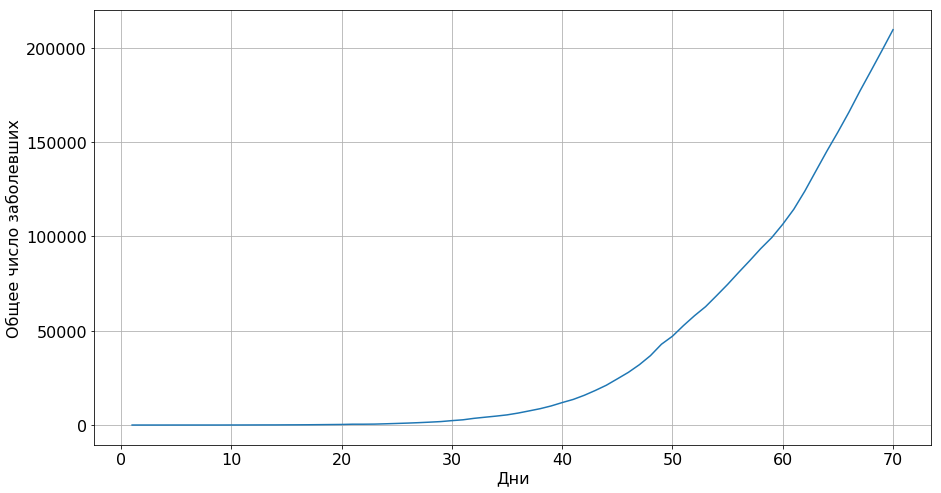

In [5]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 16})
plt.plot(df.days,df.total_cases)
plt.xlabel("Дни")
plt.ylabel("Общее число заболевших")
plt.grid()
plt.show()

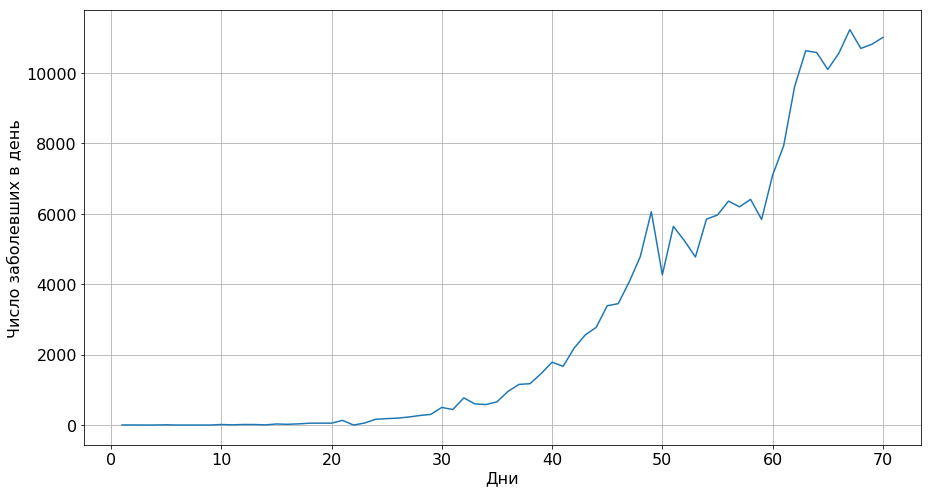

In [6]:
plt.figure(figsize=(15,8))
plt.plot(df.days,df.new_cases)
plt.xlabel("Дни")
plt.ylabel("Число заболевших в день")
plt.grid()
plt.show()

Разобьем данные на обучение и тест, также нам понадобится логарифм таргета

In [7]:
X_train, y_train = df["days"][:train_size].values, df["total_cases"][:train_size].values
X_test, y_test = df["days"][train_size:].values, df["total_cases"][train_size:].values
X, y = df["days"].values, df["total_cases"].values
y_train_log,y_test_log, y_log = np.log(y_train), np.log(y_test), np.log(y)

X_train_pol = get_polinom(X_train, 1)
X_test_pol = get_polinom(X_test, 1)
X_pol = get_polinom(X, 1)

X_future = np.arange(1,200)

Обучим кривую $y \approx e^{\theta_0 + \theta_1x}$, для этого возьмем логарфм от числа заболевших и обучим на эти данные прямую: $\ln(y) \approx \theta_0 + \theta_1x$

In [8]:
theta_opt = mnk_with_reg(X_train,y_train_log,C=1)
y_pred_log = X_pol @ theta_opt
#Для получения исходной кривой, возведем e в степень наших предсказаний
y_pred = np.e**y_pred_log

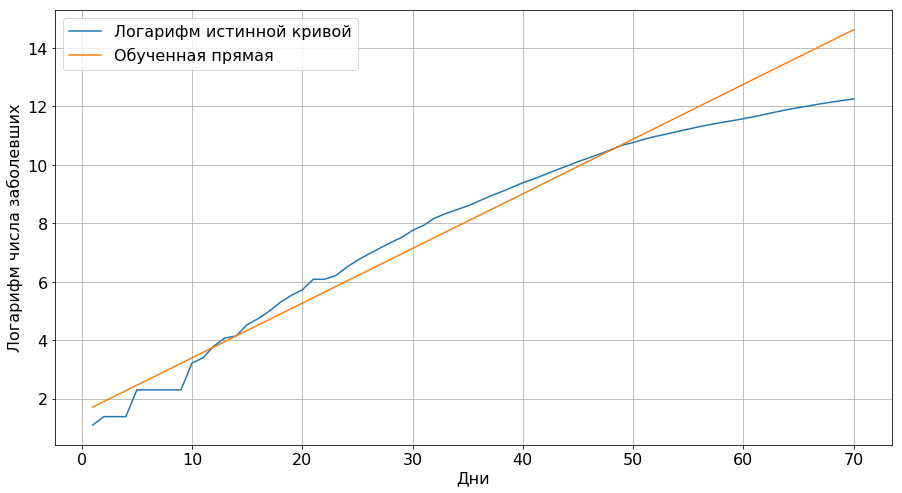

In [9]:
plt.figure(figsize=(15,8))
plt.plot(X, y_log, label = "Логарифм истинной кривой")
plt.plot(X, y_pred_log, label = "Обученная прямая")
plt.xlabel("Дни")
plt.ylabel("Логарифм числа заболевших")
plt.legend()
plt.grid()
plt.show()

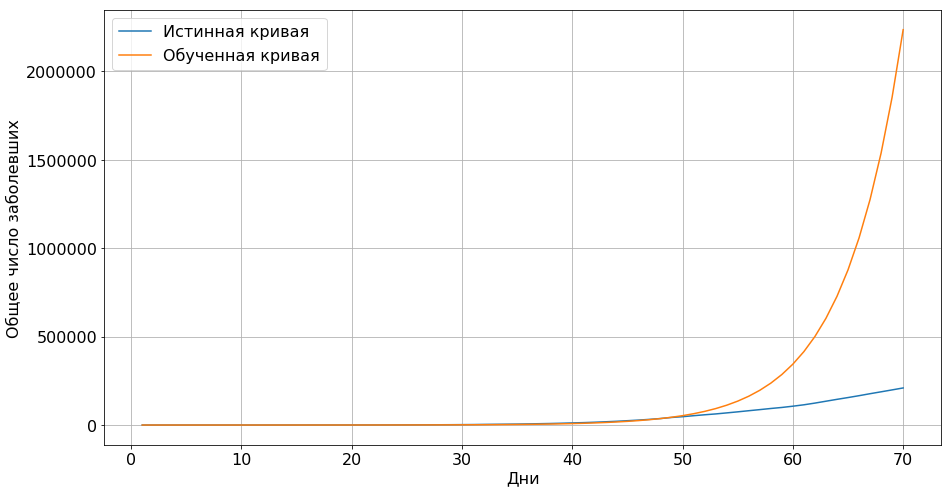

In [10]:
plt.figure(figsize=(15,8))
plt.plot(X, y, label = "Истинная кривая")
plt.plot(X, y_pred, label = "Обученная кривая")
plt.xlabel("Дни")
plt.ylabel("Общее число заболевших")
plt.legend()
plt.grid()
plt.show()

Расчитаем дисперсию шума. Так как Байесовский вывод мы умеем делать только для линейной регрессии, то и шум считаем у линейной модели (от логарифма данных)

In [11]:
D = np.mean((y_train_log - X_train_pol @ theta_opt)**2)
D

0.26471490499731226

Найдем параметры апостериорного распределения

In [12]:
mu_0 = np.array([0,0]) # априорный вектор мат ожидания
cov_matrix = 10*np.eye(2) # априорная матрица ковариации
posterior_cov_matrix, posterior_mu = get_posterior_mu_sigma(X_train_pol, y_train_log, D,mu_0, cov_matrix)

In [13]:
posterior_cov_matrix

array([[ 1.80636210e-02, -4.47858212e-04],
       [-4.47858212e-04,  1.46903542e-05]])

In [14]:
posterior_mu

array([1.62766837, 0.18454332])

In [15]:
theta_opt

array([1.52656425, 0.18704756])

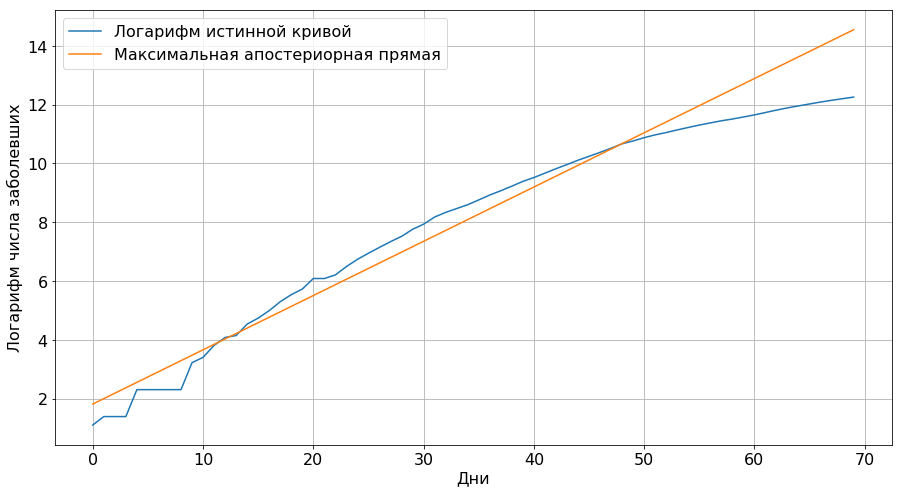

In [16]:
plt.figure(figsize=(15,8))
plt.plot(y_log,label="Логарифм истинной кривой")
plt.plot(X_pol@posterior_mu, label="Максимальная апостериорная прямая")
plt.xlabel("Дни")
plt.ylabel("Логарифм числа заболевших")
plt.legend()
plt.grid()
plt.show()

Мы нашли параметры апостериорного распределения, а значит и само апостериорное распределение. Посэмплируем много параметров $\Theta$ из апостериорного распределения и построим кривые

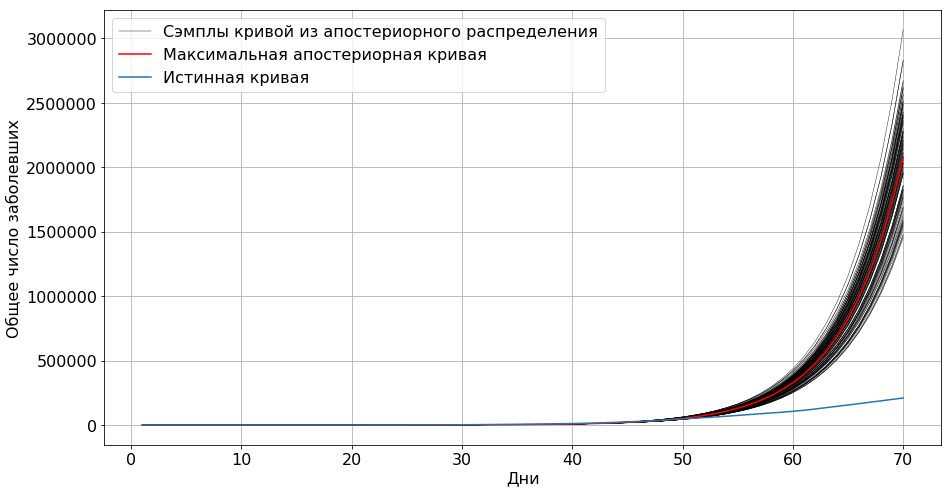

In [17]:
n = 100
samples_theta = np.random.multivariate_normal(posterior_mu, posterior_cov_matrix, n)
plt.figure(figsize=(15,8))
plt.plot(X, np.e**(X_pol@samples_theta[0]), 'k-', lw=.4,label = "Сэмплы кривой из апостериорного распределения")
for theta in samples_theta[1:]:
    plt.plot(X, np.e**(X_pol@theta), 'k-', lw=.4)
plt.plot(X,np.e**(X_pol@posterior_mu), label = "Максимальная апостериорная кривая", c="r")
plt.plot(X,y, label = "Истинная кривая")
plt.xlabel("Дни")
plt.ylabel("Общее число заболевших")
plt.legend()
plt.grid()
plt.show()

Предсказанные кривые и истинная кривая отличаются очень сильно к концу трейновых данных (60 дней) и совсем не похожи на тестовые данные. Это связано с тем, что логарифм истинной кривой является на самом деле не прямой, а какойто параболой, и как видим из графика логарифма предсказаний, наша обученная прямая к концу дат обучения стала немного откланяться, но так как там имеется дело с логарифмом, то такое откланение в конце оказалось допустимым, но когда мы обратно переходим к экспоненте, такое откланение уже становится существенным.

Сделаем предсказания вперед на 1 мая, 1 июня и 1 сентября

In [18]:
x_date = {"1 мая":np.array([1, 60]), "1 июня":np.array([1, 91]), "1 сентября":np.array([1, 183])}
res = {}
for key, value in x_date.items():
    res[key] = round(np.e**(value @ posterior_mu)).astype(int)
print(res)

{'1 мая': 327836, '1 июня': 100042958, '1 сентября': 2363914706498270}


Построим предсказательное распределение (эмпирически)

In [19]:
n = 1000
Z = []
samples_theta = np.random.multivariate_normal(posterior_mu, posterior_cov_matrix, n)
for theta in samples_theta:
    Z.append(np.e**(X_pol@theta))
Z = np.array(Z)

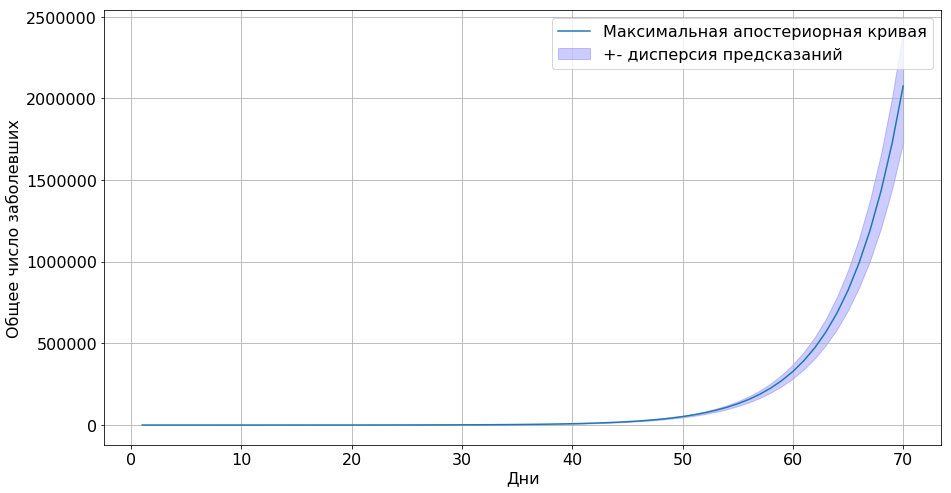

In [20]:
y_pred_poster = np.e**(X_pol@posterior_mu)
plt.figure(figsize=(15,8))
plt.plot(X, y_pred_poster, label="Максимальная апостериорная кривая")
plt.fill_between(X, y_pred_poster-np.std(Z,axis=0),y_pred_poster+np.std(Z,axis=0),color="b", alpha=.2, label="+- дисперсия предсказаний")
plt.legend()
plt.grid()
plt.xlabel("Дни")
plt.ylabel("Общее число заболевших")
plt.show()

Предсказания модели $y \approx e^{\theta_0 + \theta_1x}$ оказались очень грустными. По тестовым данным видно, что предсказания далеки от реальности.

Воспользуемся другой моделью:

\begin{equation*}
y \approx \int\limits_{-\infty}^x e^{\theta_0 + \theta_1 t + \theta_2t^2}\,dt
\end{equation*}

Для обучения такой кривой необходимо вытащить показатель экспоненты.

Для начала возьмем производную от обоих частей уравнения, чтобы избавиться от интеграла. Производную от $y$ мы знаем, это столбец new_cases, осталось взять производную от интеграла, но и тут все просто, производная от интеграла с переменным верхним пределом равна подинтегральному выражению от того же аргумента, что и в верхнем пределе интеграла.

\begin{equation*}
y' \approx e^{\theta_0 + \theta_1x + \theta_2x^2}
\end{equation*}

Как и в первой модели осталось просто взять логарифм

\begin{equation*}
\ln(y') \approx \theta_0 + \theta_1x + \theta_2x^2
\end{equation*}

Загрузим данные, теперь нам еще понадобится столбец new_cases в качестве производной

In [21]:
X_train, y_train, y_train_div  = df["days"][:train_size].values, df["total_cases"][:train_size].values, df["new_cases"][:train_size].values
X_test, y_test, y_test_div = df["days"][train_size:].values, df["total_cases"][train_size:].values, df["new_cases"][train_size:].values
X, y, y_div = df["days"].values, df["total_cases"].values, df["new_cases"].values

y_train_div[y_train_div==0]=1
y_test_div[y_test_div==0]=1
y_div[y_div==0]=1

y_train_div_log,y_test_div_log, y_div_log = np.log(y_train_div), np.log(y_test_div), np.log(y_div)

X_train_pol = get_polinom(X_train, 2)
X_test_pol = get_polinom(X_test, 2)
X_pol = get_polinom(X, 2)

Обучим квадратичную функцию: $\ln(y') \approx \theta_0 + \theta_1x + \theta_2x^2$

In [22]:
theta_opt = mnk_with_reg(X_train,y_train_div_log,n=2)
y_pred_div_log = X_pol@theta_opt

Для получения предсказанной кривой из квадратичной функции, нам нужно взять интеграл:
\begin{equation*}
y \approx \int\limits_{-\infty}^x e^{\theta_0 + \theta_1 t + \theta_2t^2}\,dt
\end{equation*}

Его можно посчитать численно. Посчитаем его сразу для всех точек $Х$

In [23]:
y_pred = expint(X, theta_opt)

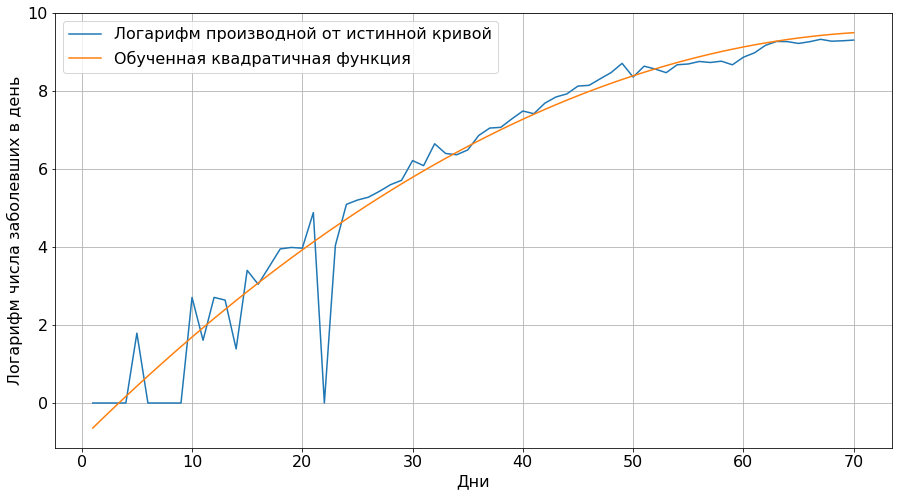

In [24]:
plt.figure(figsize=(15,8))
plt.plot(X, y_div_log, label = "Логарифм производной от истинной кривой")
plt.plot(X, y_pred_div_log, label = "Обученная квадратичная функция")
plt.xlabel("Дни")
plt.ylabel("Логарифм числа заболевших в день")
plt.legend()
plt.grid()
plt.show()

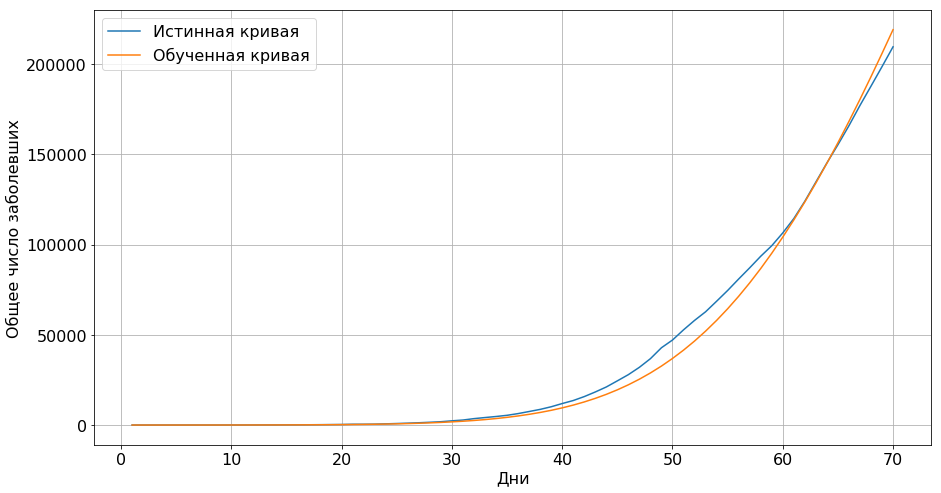

In [25]:
plt.figure(figsize=(15,8))
plt.plot(X, y, label = "Истинная кривая")
plt.plot(X, y_pred, label = "Обученная кривая")
plt.xlabel("Дни")
plt.ylabel("Общее число заболевших")
plt.legend()
plt.grid()
plt.show()

Найдем дисперсию шума

In [26]:
D = np.mean((y_train_div_log - X_train_pol @ theta_opt)**2)
D

0.5394815693418399

И апостериорное распределение параметров

In [27]:
mu_0 =np.array([0,0,0])
cov_matrix = 10*np.eye(3)
posterior_cov_matrix, posterior_mu = get_posterior_mu_sigma(X_train_pol, y_train_div_log, D,mu_0, cov_matrix)

In [28]:
posterior_cov_matrix

array([[ 8.58199818e-02, -5.67333616e-03,  7.81446688e-05],
       [-5.67333616e-03,  4.92033047e-04, -7.58317626e-06],
       [ 7.81446688e-05, -7.58317626e-06,  1.24431875e-07]])

In [29]:
posterior_mu

array([-1.06062511,  0.28909754, -0.0019999 ])

In [30]:
theta_opt

array([-0.91946559,  0.27970846, -0.00187018])

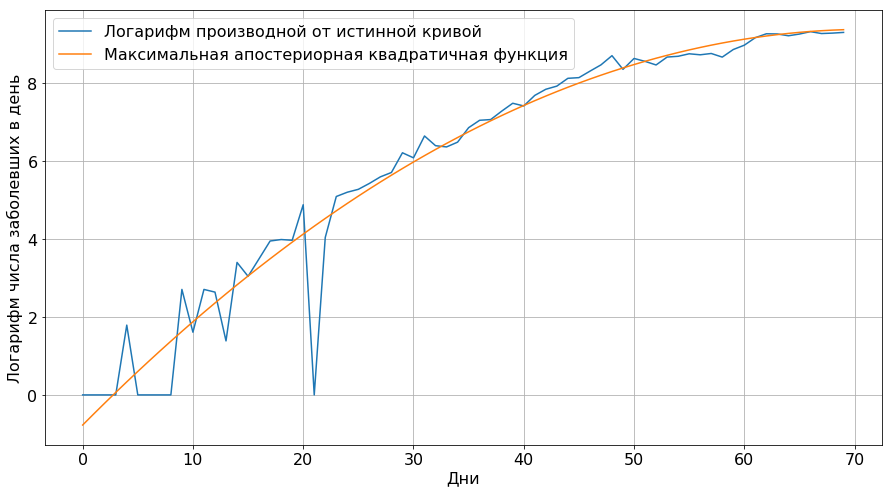

In [31]:
plt.figure(figsize=(15,8))
plt.plot(y_div_log,label="Логарифм производной от истинной кривой")
plt.plot(X_pol@posterior_mu, label="Максимальная апостериорная квадратичная функция")
plt.xlabel("Дни")
plt.ylabel("Логарифм числа заболевших в день")
plt.legend()
plt.grid()
plt.show()

Посэмплируем много параметров $\Theta$ из апостериорного распределения и построим кривые

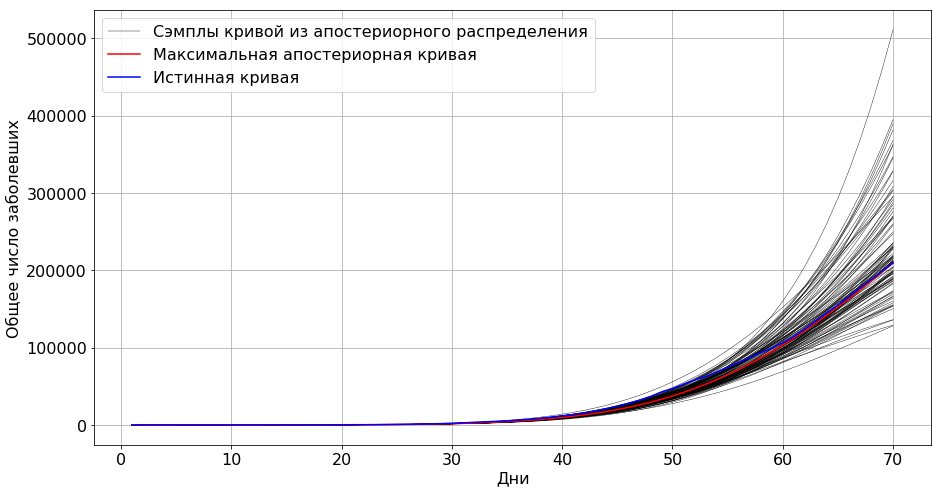

In [32]:
n = 100
samples_theta = np.random.multivariate_normal(posterior_mu, posterior_cov_matrix, n)
plt.figure(figsize=(15,8))
plt.plot(X, expint(X, samples_theta[0]), 'k-', lw=.4,label = "Сэмплы кривой из апостериорного распределения")
for theta in samples_theta[1:]:
    plt.plot(X, expint(X, theta), 'k-', lw=.4)
plt.plot(X, expint(X, posterior_mu), label = "Максимальная апостериорная кривая", c="r")
plt.plot(X,y, label = "Истинная кривая", c="blue")
plt.xlabel("Дни")
plt.ylabel("Общее число заболевших")
plt.legend()
plt.grid()
plt.show()

Как видим, кривые данной модели, ведут себя гораздо лучше, чем у прошлой, даже на тестовых данных (после 60 дней)

Загляним в будущее и посмотрим, как дела там

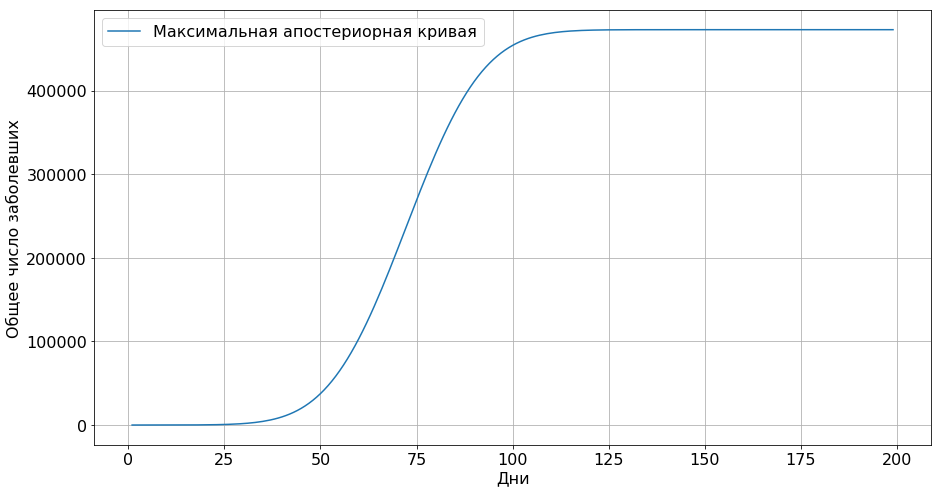

In [33]:
y_pred_all = expint(X_future, posterior_mu)
plt.figure(figsize=(15,8))
plt.plot(X_future,y_pred_all,label = "Максимальная апостериорная кривая")
plt.xlabel("Дни")
plt.ylabel("Общее число заболевших")
plt.legend()
plt.grid()

Предсказания не самые радостные, но уже более правдивые

Построим предсказательное распределение (эмпирически)

In [34]:
n = 1000
Z = []
samples_theta = np.random.multivariate_normal(posterior_mu, posterior_cov_matrix, n)
for theta in samples_theta:
    pred = expint(X, theta)
    if pred.max() != np.inf:
        Z.append(expint(X, theta))
Z = np.array(Z)

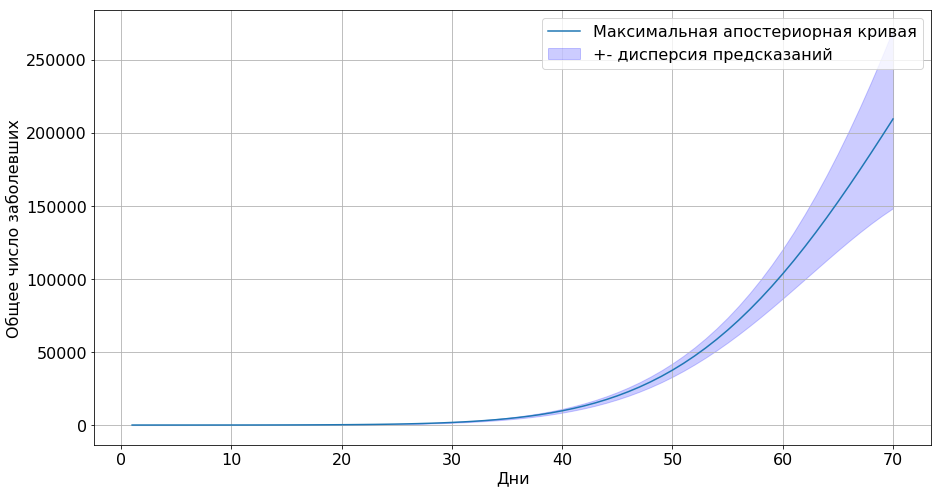

In [35]:
y_pred_poster = expint(X, posterior_mu)
plt.figure(figsize=(15,8))
plt.plot(X, y_pred_poster, label="Максимальная апостериорная кривая")
plt.fill_between(X, y_pred_poster-np.std(Z,axis=0),y_pred_poster+np.std(Z,axis=0),color="b", alpha=.2, label="+- дисперсия предсказаний")
plt.legend()
plt.grid()
plt.xlabel("Дни")
plt.ylabel("Общее число заболевших")
plt.show()

Построим предсказательное распределение до конца пандемии

In [36]:
n = 1000
Z = []
samples_theta = np.random.multivariate_normal(posterior_mu, posterior_cov_matrix, n)
for theta in samples_theta:
    pred = expint(X_future, theta)
    if pred.max() != np.inf:
        Z.append(expint(X_future, theta))
Z = np.array(Z)

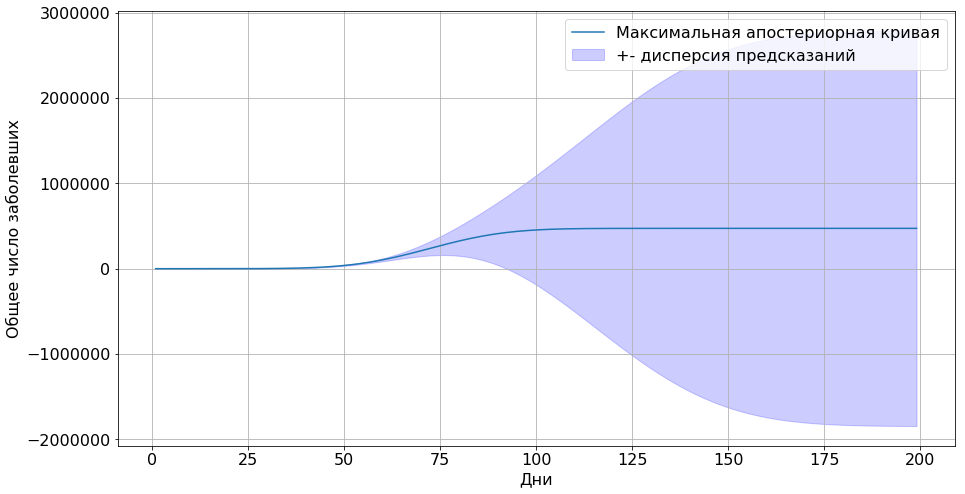

In [37]:
y_pred_poster = expint(X_future, posterior_mu)
plt.figure(figsize=(15,8))
plt.plot(X_future, y_pred_poster, label="Максимальная апостериорная кривая")
plt.fill_between(X_future, y_pred_poster-np.std(Z,axis=0),y_pred_poster+np.std(Z,axis=0),color="b", alpha=.2, label="+- дисперсия предсказаний")
plt.legend()
plt.grid()
plt.xlabel("Дни")
plt.ylabel("Общее число заболевших")
plt.show()

Сделаем предсказания вперед на 1 мая, 1 июня и 1 сентября

In [38]:
x_date = {"1 мая":np.array([60]), "1 июня":np.array([91]), "1 сентября":np.array([183])}
res = {}
for key, value in x_date.items():
    res[key] = round(expint(value, posterior_mu)[0]).astype(int)
print(res)

{'1 мая': 103447, '1 июня': 417051, '1 сентября': 472951}


In [39]:
n = 1000
Z = []
X_final = np.array([200])
samples_theta = np.random.multivariate_normal(posterior_mu, posterior_cov_matrix, n)
for theta in samples_theta:
    Z.append(expint(X_final, theta)[0])
Z = np.array(Z)

Построим оптимистичный и пессимистичный прогноз числа заболевших в России к концу пандемии

In [40]:
text = f"Прогноз числа заболевших в России: Оптимистичный (10-й процентиль) - {round(np.percentile(Z,10)).astype(int)}, \nпессимистичный (90-й процентиль) - {round(np.percentile(Z,90)).astype(int)}"
print(text)

Прогноз числа заболевших в России: Оптимистичный (10-й процентиль) - 245860, 
пессимистичный (90-й процентиль) - 1270086


## Проведем такойже анализ на данных пандемии в Америке

In [41]:
df = pd.read_csv("owid-covid-data.csv")

In [42]:
df = pd.read_csv("owid-covid-data.csv")
df = df[(df.location=="United States") & (df.date>="2020-02-22")].reset_index()[use_col]
df["days"] = range(1,df.shape[0]+1)

train_size = int(df.shape[0] * 0.9)
print("train_size,: ", train_size)

train_size,:  72


In [43]:
X_train, y_train, y_train_div  = df["days"][:train_size].values, df["total_cases"][:train_size].values, df["new_cases"][:train_size].values
X_test, y_test, y_test_div = df["days"][train_size:].values, df["total_cases"][train_size:].values, df["new_cases"][train_size:].values
X, y, y_div = df["days"].values, df["total_cases"].values, df["new_cases"].values

y_train_div[y_train_div==0]=1
y_test_div[y_test_div==0]=1
y_div[y_div==0]=1

y_train_div_log,y_test_div_log, y_div_log = np.log(y_train_div), np.log(y_test_div), np.log(y_div)

X_train_pol = get_polinom(X_train, 2)
X_test_pol = get_polinom(X_test, 2)
X_pol = get_polinom(X, 2)

In [44]:
theta_opt = mnk_with_reg(X_train,y_train_div_log,n=2)
y_pred_div_log = X_pol@theta_opt
y_pred = expint(X, theta_opt)

In [45]:
D = np.mean((y_train_div_log - X_train_pol @ theta_opt)**2)
D

0.45664792913368707

In [46]:
mu_0 =np.array([0,0,0])
cov_matrix = 10*np.eye(3)
posterior_cov_matrix, posterior_mu = get_posterior_mu_sigma(X_train_pol, y_train_div_log, D,mu_0, cov_matrix)

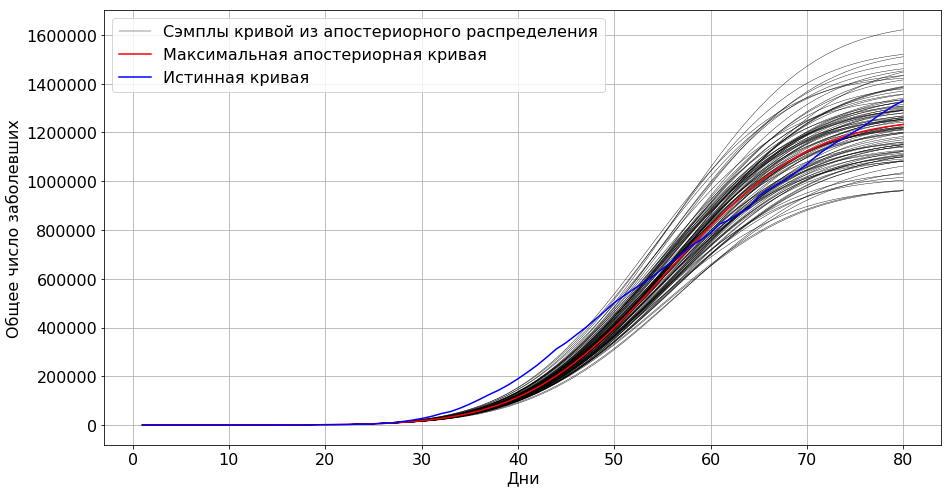

In [47]:
n = 100
samples_theta = np.random.multivariate_normal(posterior_mu, posterior_cov_matrix, n)
plt.figure(figsize=(15,8))
plt.plot(X, expint(X, samples_theta[0]), 'k-', lw=.4,label = "Сэмплы кривой из апостериорного распределения")
for theta in samples_theta[1:]:
    plt.plot(X, expint(X, theta), 'k-', lw=.4)
plt.plot(X, expint(X, posterior_mu), label = "Максимальная апостериорная кривая", c="r")
plt.plot(X,y, label = "Истинная кривая", c="blue")
plt.xlabel("Дни")
plt.ylabel("Общее число заболевших")
plt.legend()
plt.grid()
plt.show()

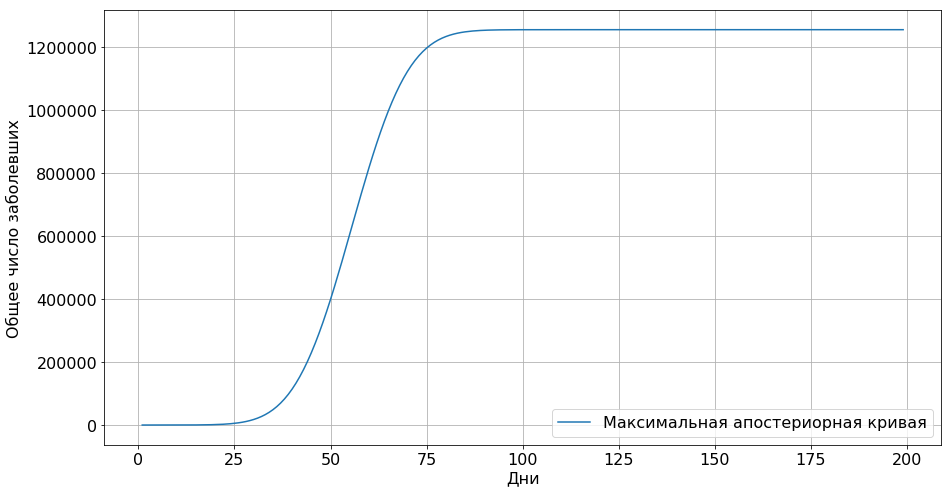

In [48]:
y_pred_all = expint(X_future, posterior_mu)
plt.figure(figsize=(15,8))
plt.plot(X_future,y_pred_all,label = "Максимальная апостериорная кривая")
plt.xlabel("Дни")
plt.ylabel("Общее число заболевших")
plt.legend()
plt.grid()

In [49]:
n = 1000
Z = []
samples_theta = np.random.multivariate_normal(posterior_mu, posterior_cov_matrix, n)
for theta in samples_theta:
    pred = expint(X, theta)
    if pred.max() != np.inf:
        Z.append(expint(X, theta))
Z = np.array(Z)

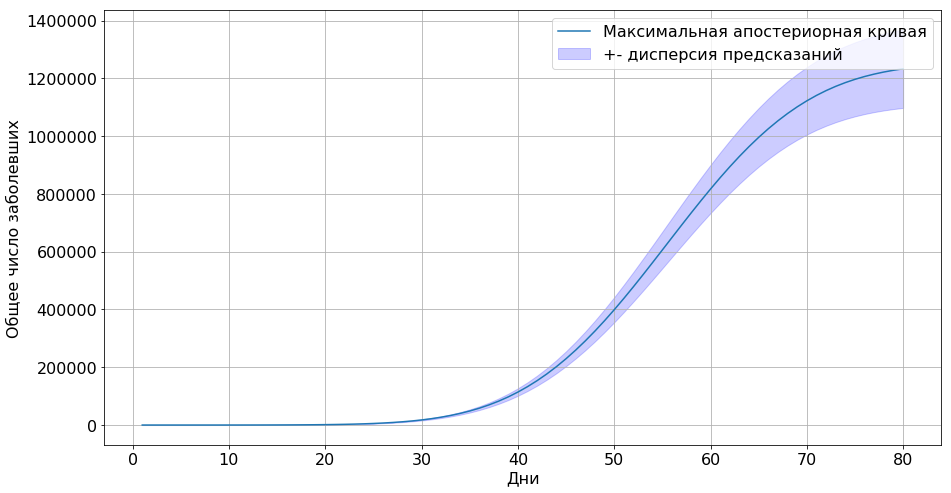

In [50]:
y_pred_poster = expint(X, posterior_mu)
plt.figure(figsize=(15,8))
plt.plot(X, y_pred_poster, label="Максимальная апостериорная кривая")
plt.fill_between(X, y_pred_poster-np.std(Z,axis=0),y_pred_poster+np.std(Z,axis=0),color="b", alpha=.2, label="+- дисперсия предсказаний")
plt.legend()
plt.grid()
plt.xlabel("Дни")
plt.ylabel("Общее число заболевших")
plt.show()

In [51]:
n = 1000
Z = []
samples_theta = np.random.multivariate_normal(posterior_mu, posterior_cov_matrix, n)
for theta in samples_theta:
    pred = expint(X_future, theta)
    if pred.max() != np.inf:
        Z.append(expint(X_future, theta))
Z = np.array(Z)

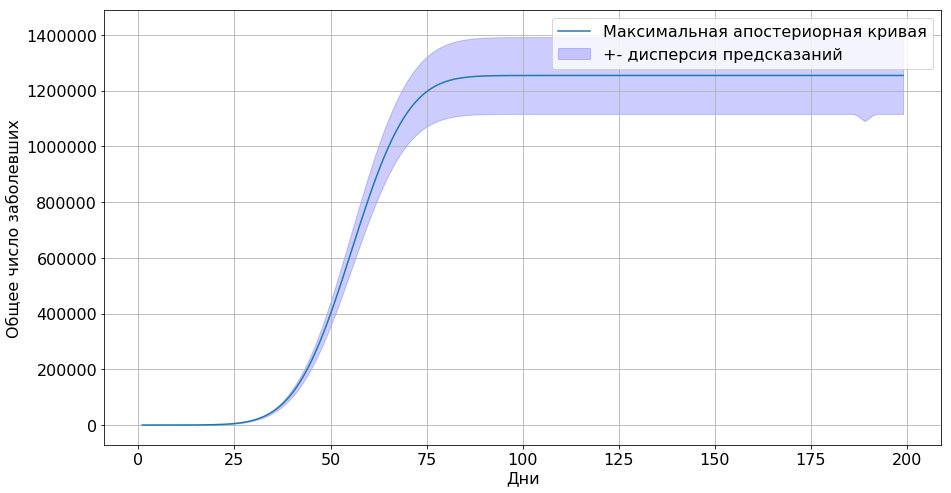

In [52]:
y_pred_poster = expint(X_future, posterior_mu)
plt.figure(figsize=(15,8))
plt.plot(X_future, y_pred_poster, label="Максимальная апостериорная кривая")
plt.fill_between(X_future, y_pred_poster-np.std(Z,axis=0),y_pred_poster+np.std(Z,axis=0),color="b", alpha=.2, label="+- дисперсия предсказаний")
plt.legend()
plt.grid()
plt.xlabel("Дни")
plt.ylabel("Общее число заболевших")
plt.show()

In [53]:
n = 1000
Z = []
X_final = np.array([200])
samples_theta = np.random.multivariate_normal(posterior_mu, posterior_cov_matrix, n)
for theta in samples_theta:
    Z.append(expint(X_final, theta)[0])
Z = np.array(Z)

In [54]:
text = f"Прогноз числа заболевших в Америке: Оптимистичный (10-й процентиль) - {round(np.percentile(Z,10)).astype(int)}, \nпессимистичный (90-й процентиль) - {round(np.percentile(Z,90)).astype(int)}"
print(text)

Прогноз числа заболевших в Америке: Оптимистичный (10-й процентиль) - 1108696, 
пессимистичный (90-й процентиль) - 1453137


## Проведем такойже анализ на данных пандемии в Испании

In [55]:
df = pd.read_csv("owid-covid-data.csv")
df = df[(df.location=="Spain") & (df.date>="2020-02-25") & (df.new_cases>0)].reset_index()[use_col]
df["days"] = range(1,df.shape[0]+1)

train_size = int(df.shape[0] * 0.9)
print("train_size,: ", train_size)

train_size,:  67


In [56]:
X_train, y_train, y_train_div  = df["days"][:train_size].values, df["total_cases"][:train_size].values, df["new_cases"][:train_size].values
X_test, y_test, y_test_div = df["days"][train_size:].values, df["total_cases"][train_size:].values, df["new_cases"][train_size:].values
X, y, y_div = df["days"].values, df["total_cases"].values, df["new_cases"].values

y_train_div[y_train_div==0]=1
y_test_div[y_test_div==0]=1
y_div[y_div==0]=1

y_train_div_log,y_test_div_log, y_div_log = np.log(y_train_div), np.log(y_test_div), np.log(y_div)

X_train_pol = get_polinom(X_train, 2)
X_test_pol = get_polinom(X_test, 2)
X_pol = get_polinom(X, 2)

In [57]:
theta_opt = mnk_with_reg(X_train,y_train_div_log,n=2)
y_pred_div_log = X_pol@theta_opt
y_pred = expint(X, theta_opt)

In [58]:
D = np.mean((y_train_div_log - X_train_pol @ theta_opt)**2)
D

0.19399808254973086

In [59]:
mu_0 =np.array([0,0,0])
cov_matrix = 10*np.eye(3)
posterior_cov_matrix, posterior_mu = get_posterior_mu_sigma(X_train_pol, y_train_div_log, D,mu_0, cov_matrix)

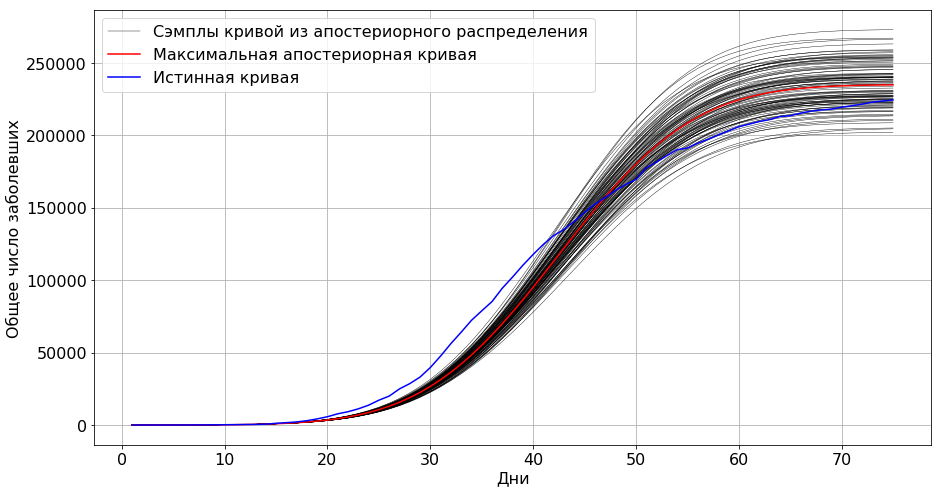

In [60]:
n = 100
samples_theta = np.random.multivariate_normal(posterior_mu, posterior_cov_matrix, n)
plt.figure(figsize=(15,8))
plt.plot(X, expint(X, samples_theta[0]), 'k-', lw=.4,label = "Сэмплы кривой из апостериорного распределения")
for theta in samples_theta[1:]:
    plt.plot(X, expint(X, theta), 'k-', lw=.4)
plt.plot(X, expint(X, posterior_mu), label = "Максимальная апостериорная кривая", c="r")
plt.plot(X,y, label = "Истинная кривая", c="blue")
plt.xlabel("Дни")
plt.ylabel("Общее число заболевших")
plt.legend()
plt.grid()
plt.show()

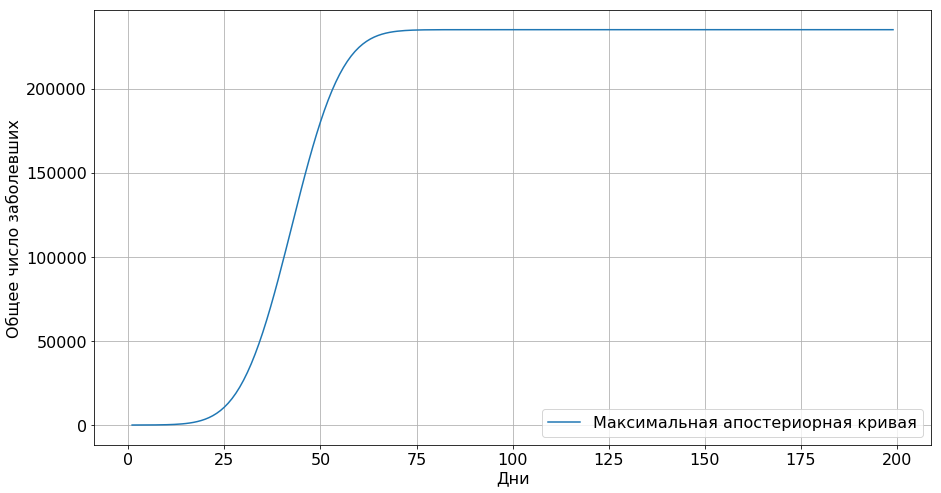

In [61]:
y_pred_all = expint(X_future, posterior_mu)
plt.figure(figsize=(15,8))
plt.plot(X_future,y_pred_all,label = "Максимальная апостериорная кривая")
plt.xlabel("Дни")
plt.ylabel("Общее число заболевших")
plt.legend()
plt.grid()

In [62]:
n = 1000
Z = []
samples_theta = np.random.multivariate_normal(posterior_mu, posterior_cov_matrix, n)
for theta in samples_theta:
    pred = expint(X, theta)
    if pred.max() != np.inf:
        Z.append(expint(X, theta))
Z = np.array(Z)

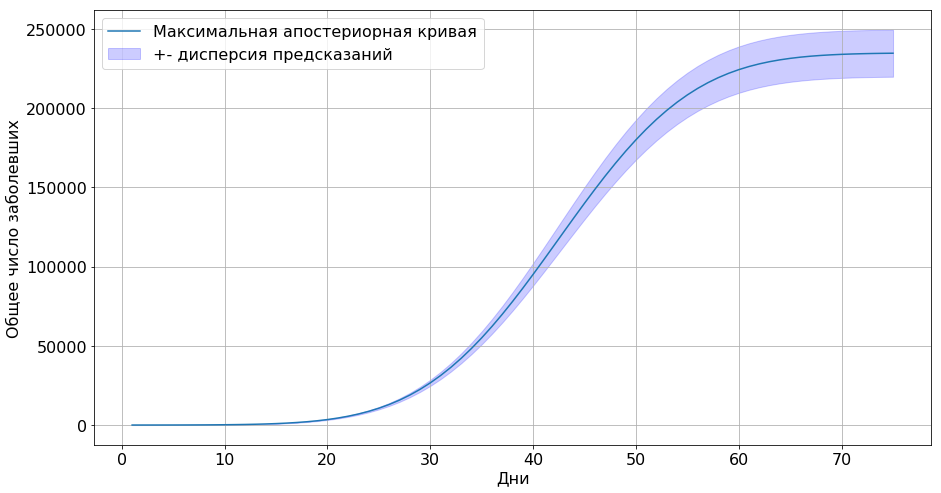

In [63]:
y_pred_poster = expint(X, posterior_mu)
plt.figure(figsize=(15,8))
plt.plot(X, y_pred_poster, label="Максимальная апостериорная кривая")
plt.fill_between(X, y_pred_poster-np.std(Z,axis=0),y_pred_poster+np.std(Z,axis=0),color="b", alpha=.2, label="+- дисперсия предсказаний")
plt.legend()
plt.grid()
plt.xlabel("Дни")
plt.ylabel("Общее число заболевших")
plt.show()

In [64]:
n = 1000
Z = []
samples_theta = np.random.multivariate_normal(posterior_mu, posterior_cov_matrix, n)
for theta in samples_theta:
    pred = expint(X_future, theta)
    if pred.max() != np.inf:
        Z.append(expint(X_future, theta))
Z = np.array(Z)

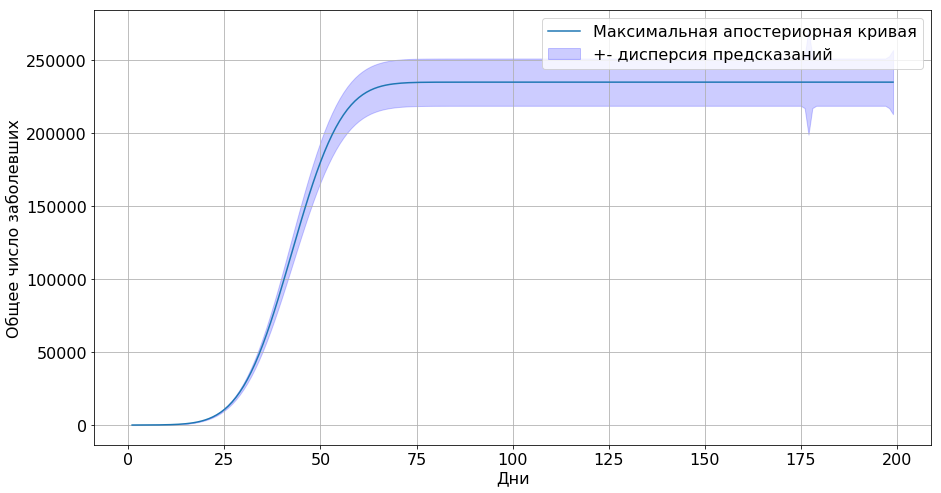

In [65]:
y_pred_poster = expint(X_future, posterior_mu)
plt.figure(figsize=(15,8))
plt.plot(X_future, y_pred_poster, label="Максимальная апостериорная кривая")
plt.fill_between(X_future, y_pred_poster-np.std(Z,axis=0),y_pred_poster+np.std(Z,axis=0),color="b", alpha=.2, label="+- дисперсия предсказаний")
plt.legend()
plt.grid()
plt.xlabel("Дни")
plt.ylabel("Общее число заболевших")
plt.show()

In [66]:
n = 1000
Z = []
X_final = np.array([200])
samples_theta = np.random.multivariate_normal(posterior_mu, posterior_cov_matrix, n)
for theta in samples_theta:
    Z.append(expint(X_final, theta)[0])
Z = np.array(Z)

In [67]:
text = f"Прогноз числа заболевших в Испании: Оптимистичный (10-й процентиль) - {round(np.percentile(Z,10)).astype(int)}, \nпессимистичный (90-й процентиль) - {round(np.percentile(Z,90)).astype(int)}"
print(text)

Прогноз числа заболевших в Испании: Оптимистичный (10-й процентиль) - 212593, 
пессимистичный (90-й процентиль) - 255861


## Кластерный анализ

Обучим модель в виде сигмоида на разных странах и попробуем кластеризовать их в зависимости от обученных параметров $\Theta$

Возьмем только те дни, в которых число случаев заражения больше двух, и только те страны, где таких дней больше 5.

In [68]:
df = pd.read_csv("owid-covid-data.csv")
location = df.location.drop_duplicates().values
Theta_opt = []
Location = []
for loc in location:
    df1 = df[(df.location==loc) & (df.new_cases>2)].reset_index()[use_col]
    df1["days"] = range(1,df1.shape[0]+1)
    if len(df1) > 5:
        Theta_opt.append(mnk_with_reg(df1.days,np.log(df1.new_cases.values),n=2))
        Location.append(loc)
        
Location = np.array(Location)
Theta_opt = np.array(Theta_opt)

Для начала посмотрим на гистограммы для каждого параметра.

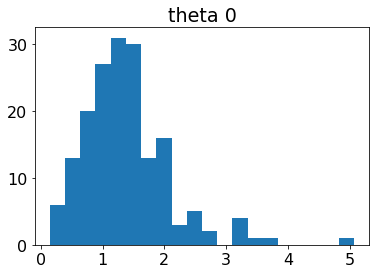

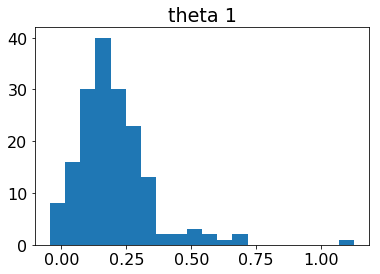

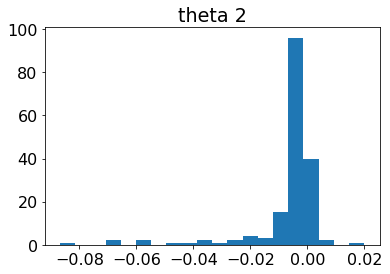

In [69]:
for i in range(3):
    plt.hist(Theta_opt[:,i], bins=20)
    plt.title(f"theta {i}")
    plt.show()

Визуализируем параметры

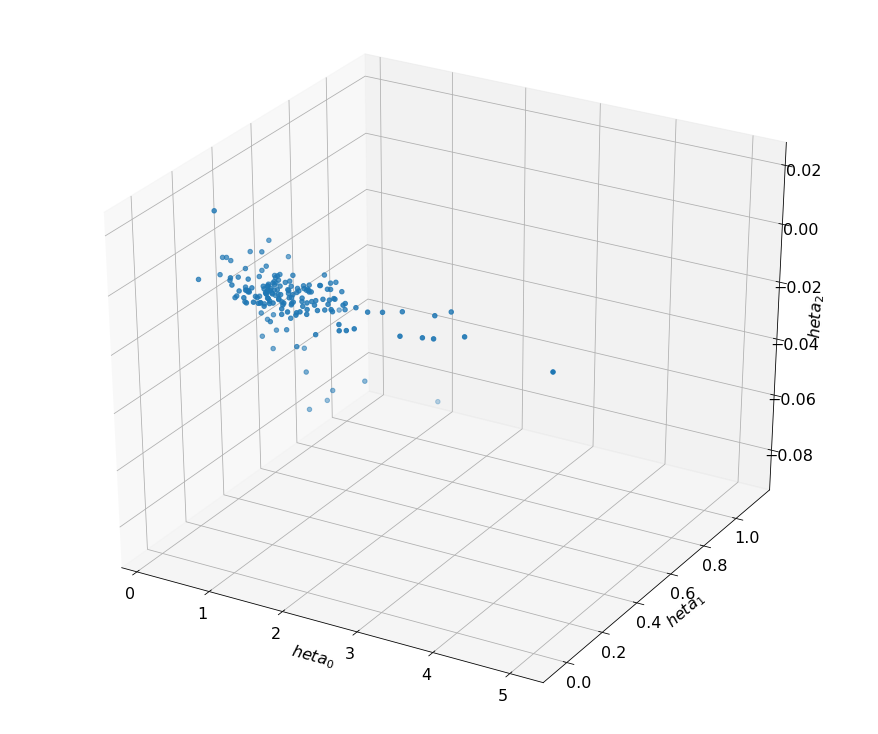

In [70]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)
ax.scatter(Theta_opt[:,0], Theta_opt[:,1], Theta_opt[:,2])
ax.set_xlabel('$\theta_0$')
ax.set_ylabel('$\theta_1$')
ax.set_zlabel('$\theta_2$')
plt.show()

Визуально видно один большой кластер и два маленьких, давайте обучим алгоритм кластеризации и попросим найти 3 кластера

In [71]:
from sklearn.cluster import KMeans

In [72]:
n_clusters = 3
cl = KMeans(n_clusters=n_clusters)
predict_clusters = cl.fit_predict(Theta_opt)

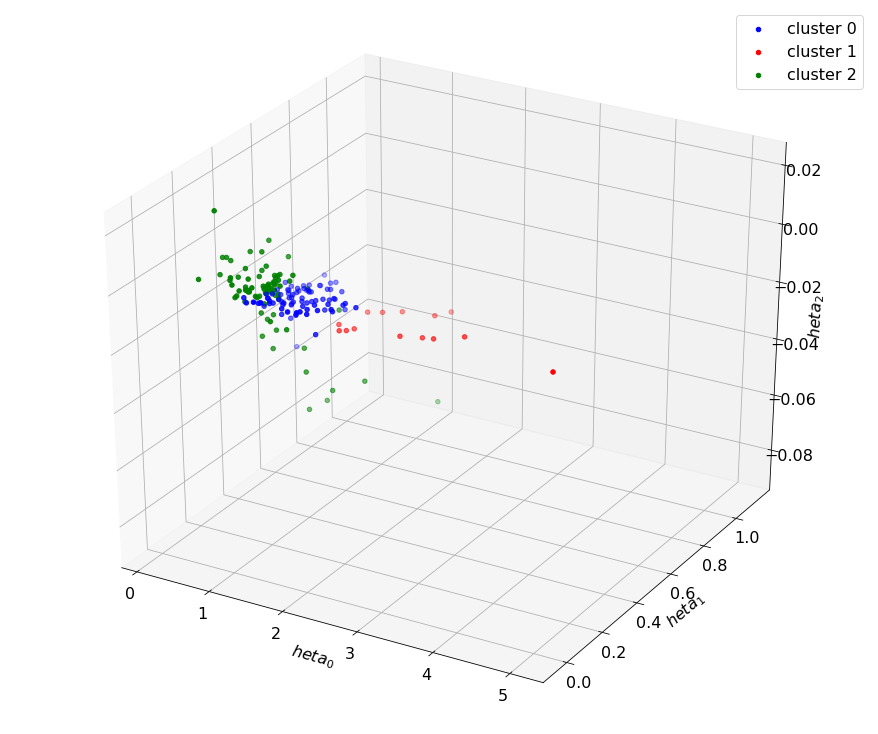

In [73]:
from mpl_toolkits.mplot3d import Axes3D
c = ["b", "r", "g"]
fig = plt.figure(figsize=(12,10))
ax = Axes3D(fig)

for i in range(n_clusters):
    ax.scatter(Theta_opt[predict_clusters==i][:,0], Theta_opt[predict_clusters==i][:,1], Theta_opt[predict_clusters==i][:,2],c = c[i], label=f"cluster {i}")
    plt.legend()
ax.set_xlabel('$\theta_0$')
ax.set_ylabel('$\theta_1$')
ax.set_zlabel('$\theta_2$')
plt.show()

Визуализируем кривые из каждого кластера

******************** cluster 0 ********************


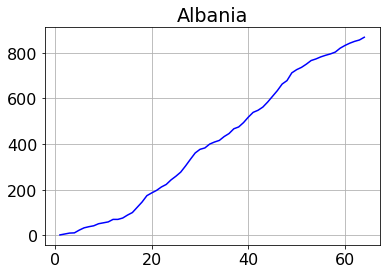

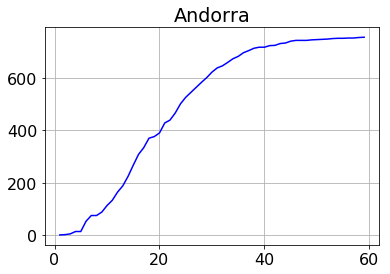

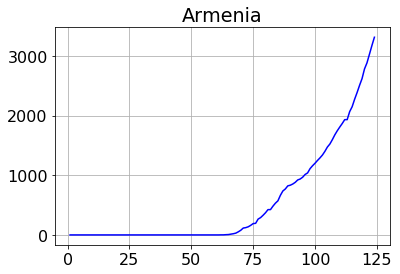

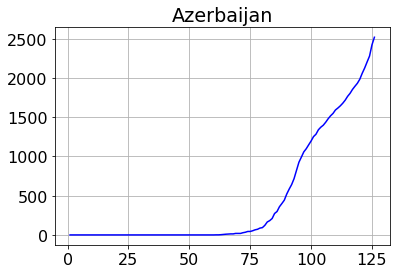

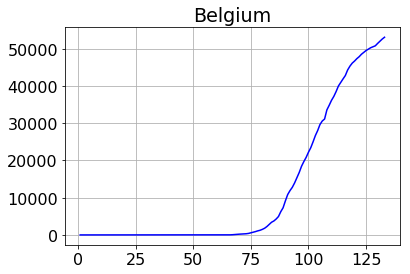

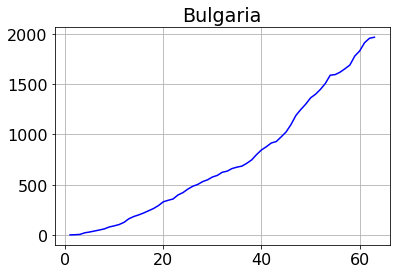

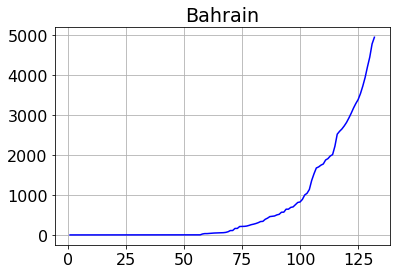

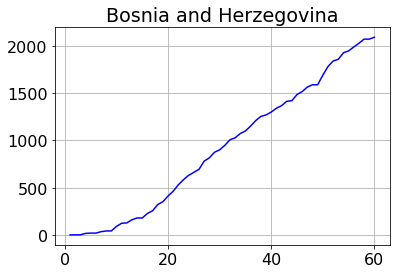

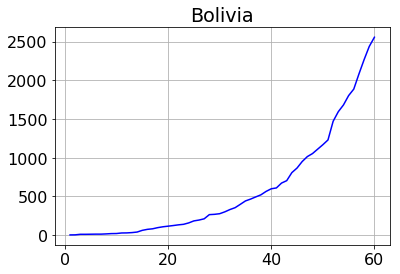

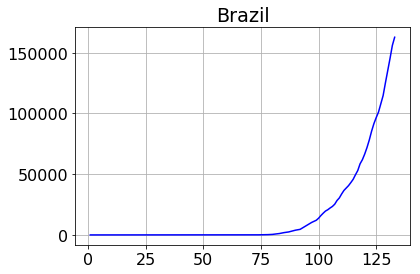

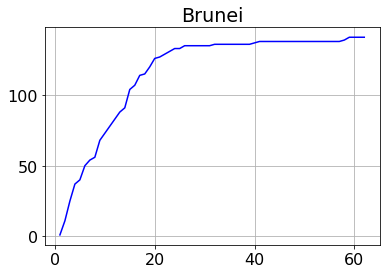

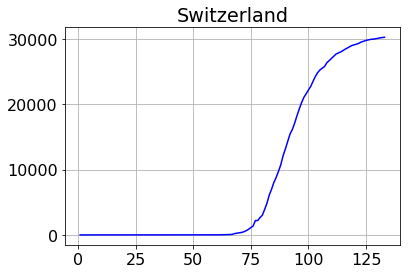

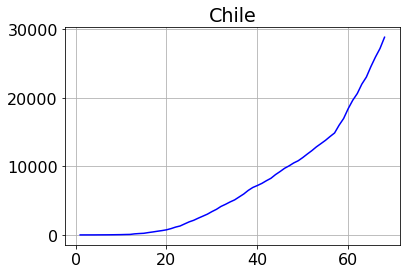

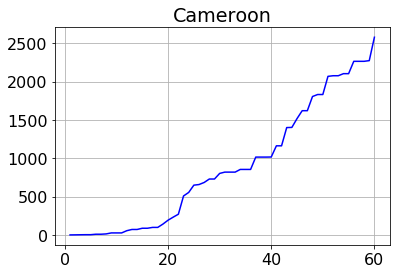

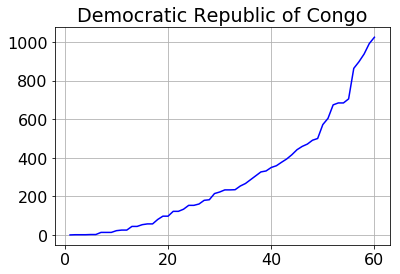

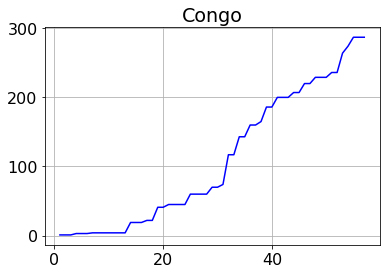

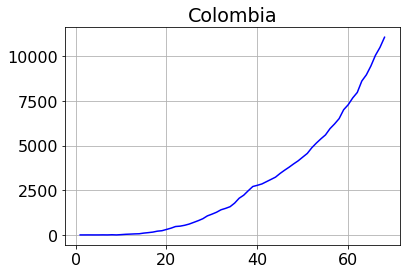

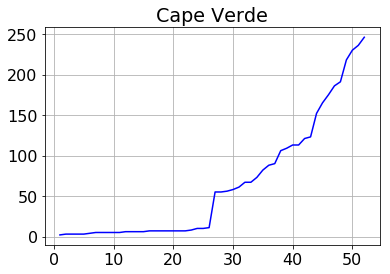

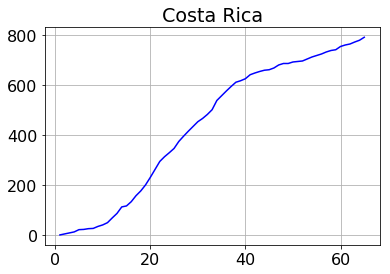

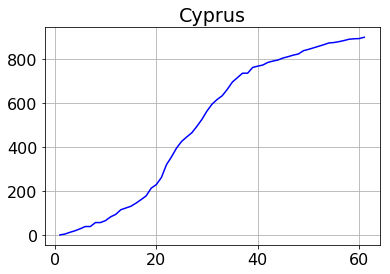

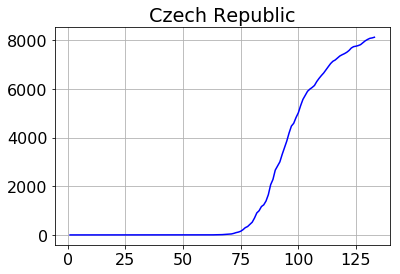

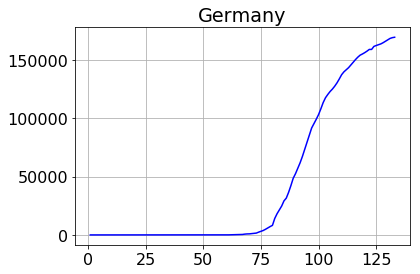

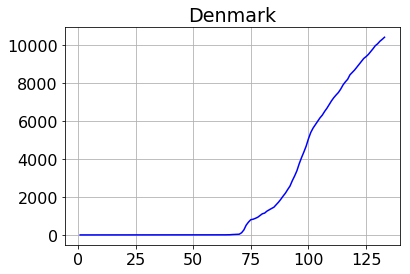

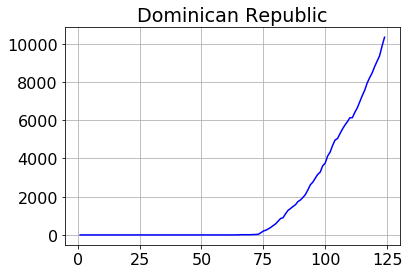

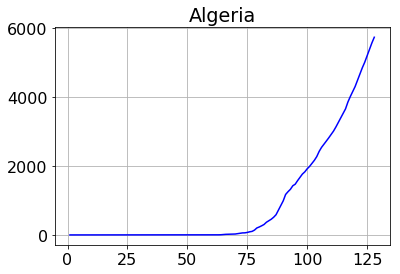

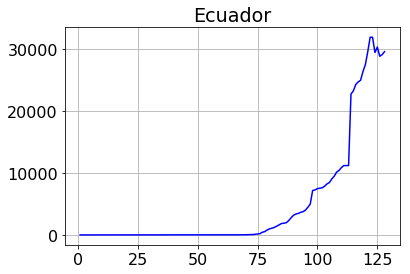

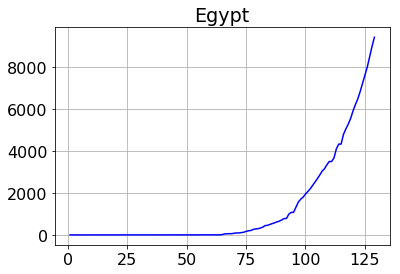

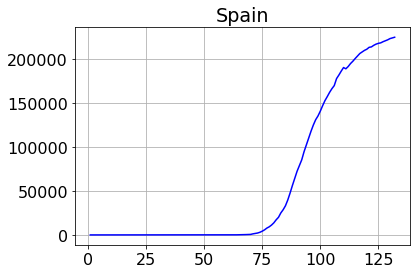

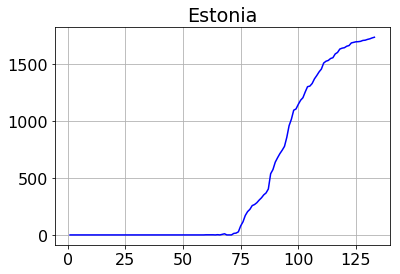

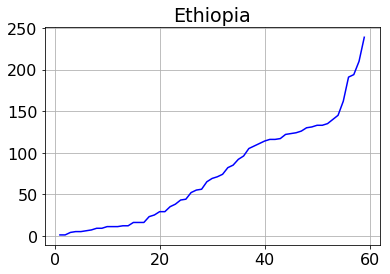

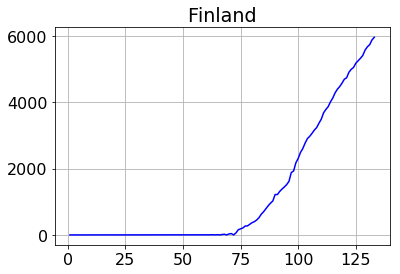

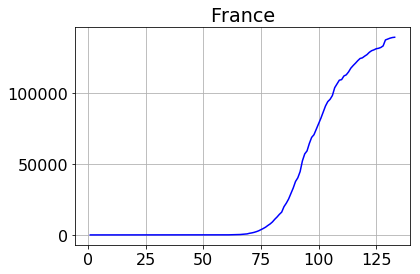

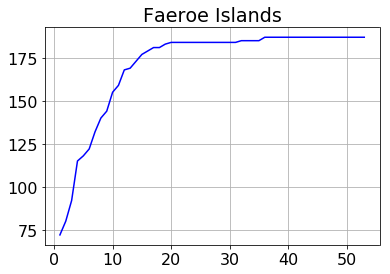

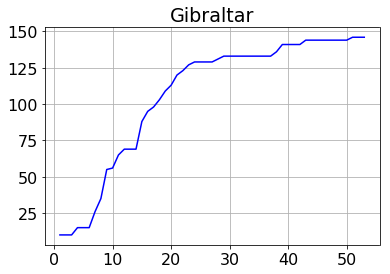

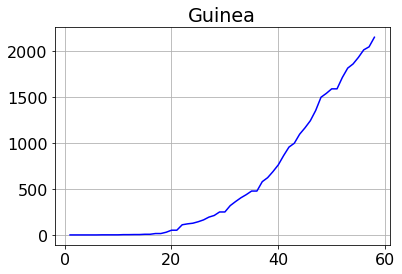

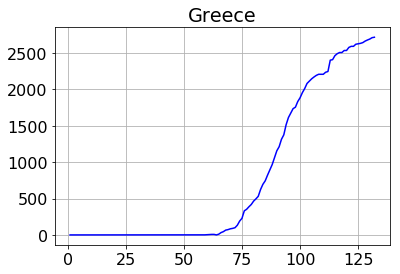

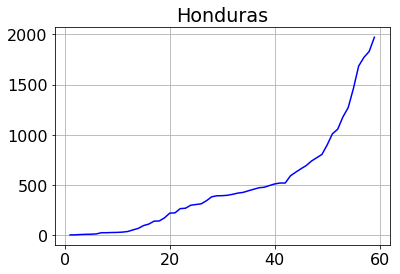

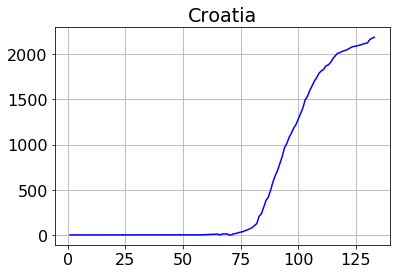

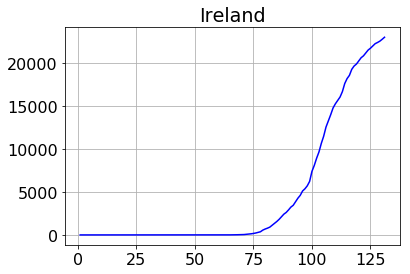

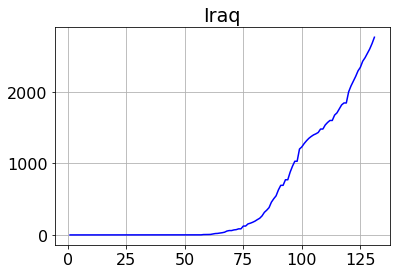

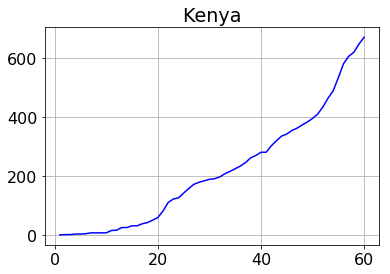

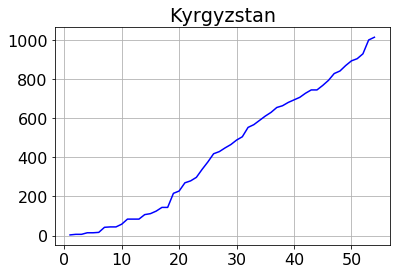

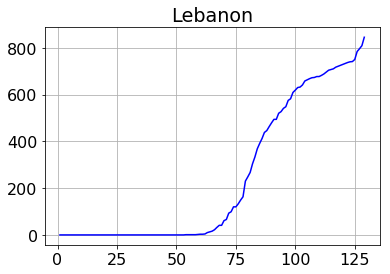

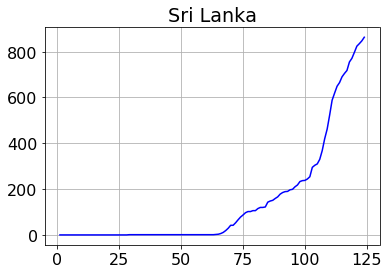

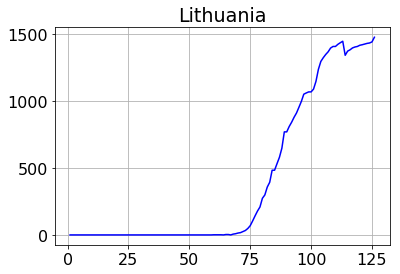

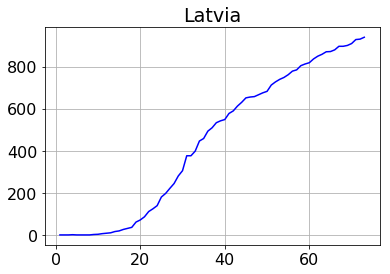

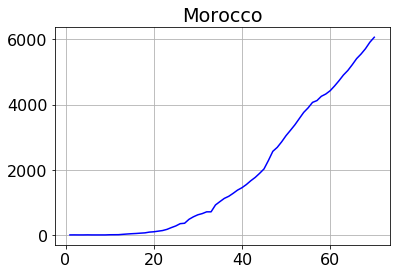

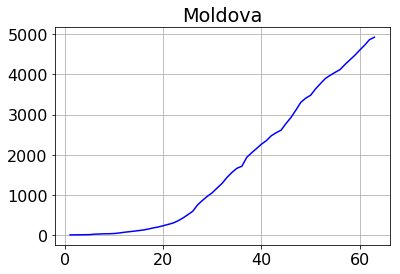

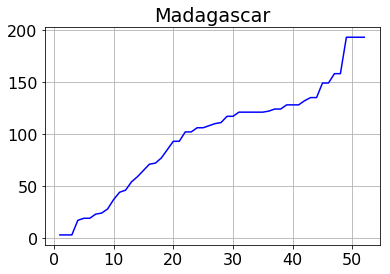

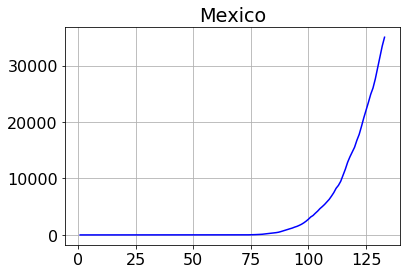

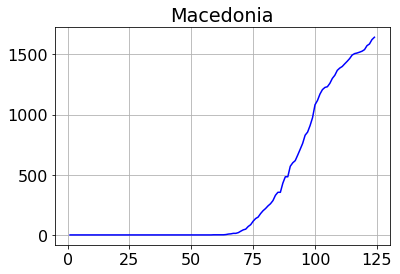

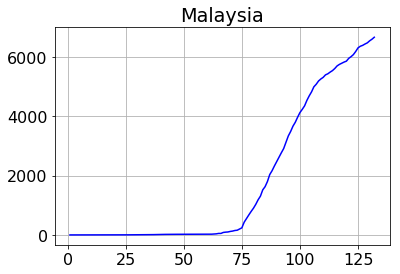

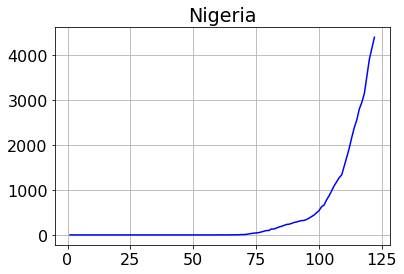

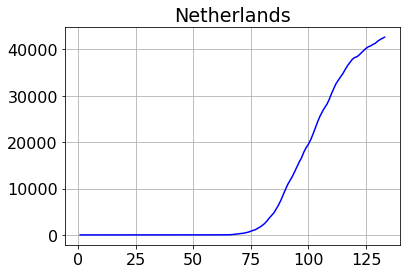

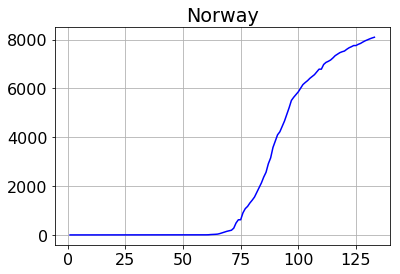

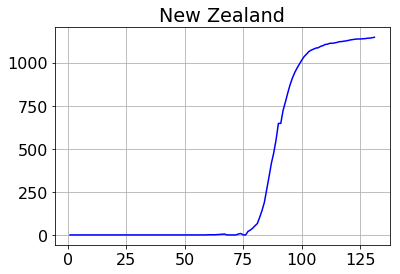

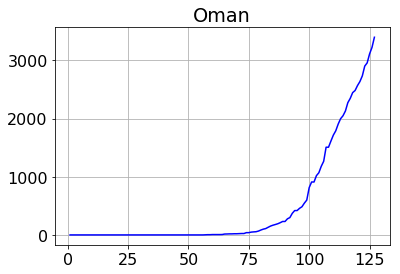

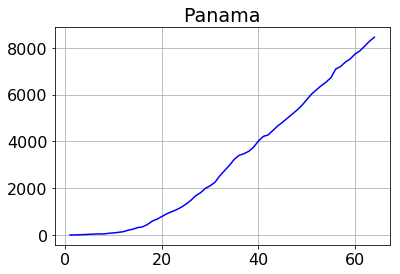

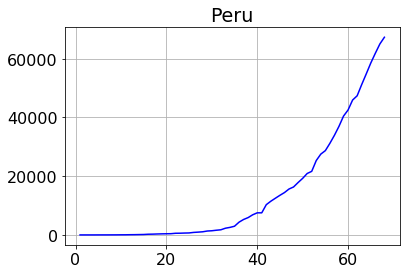

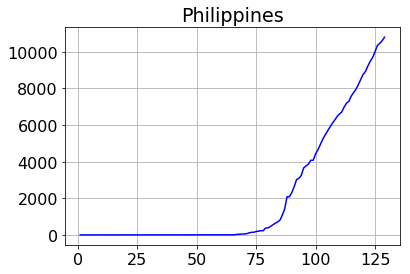

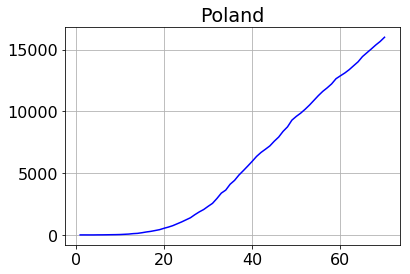

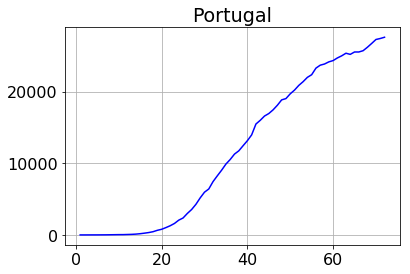

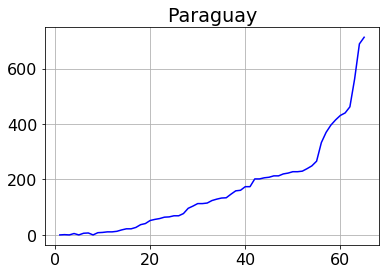

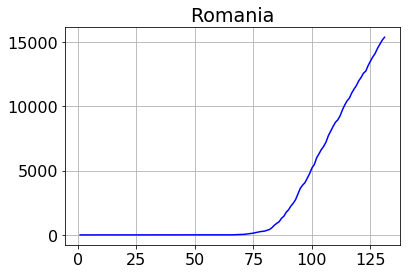

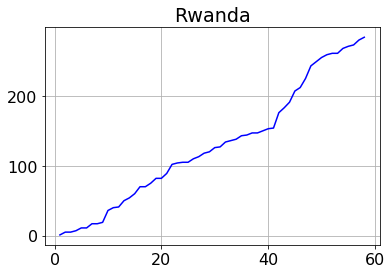

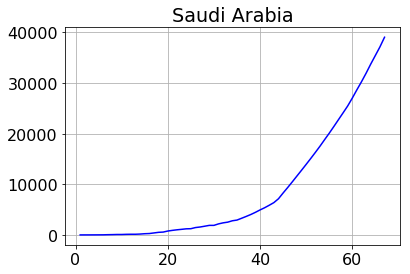

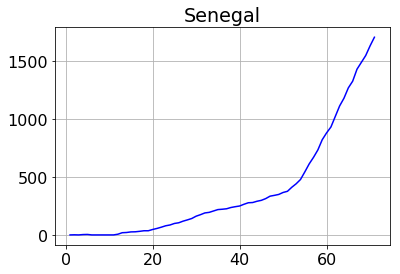

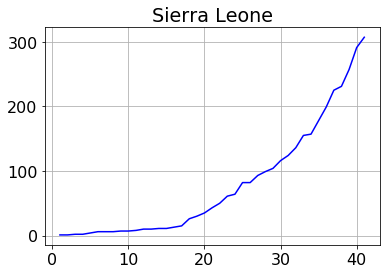

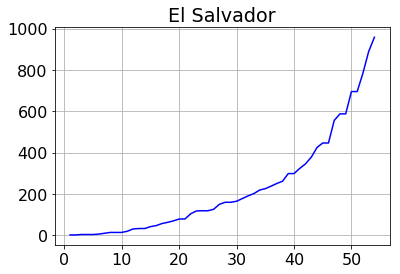

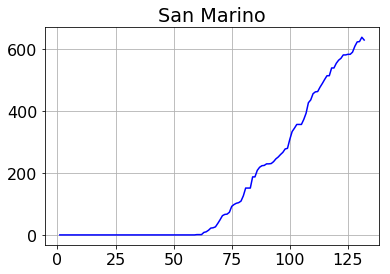

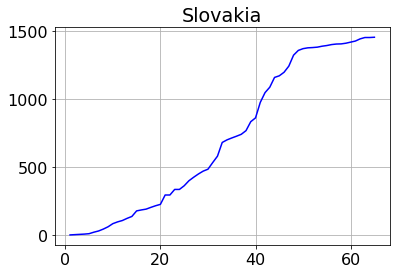

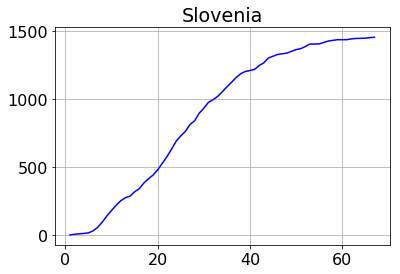

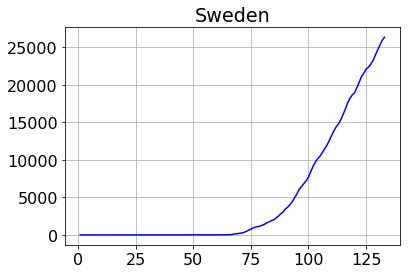

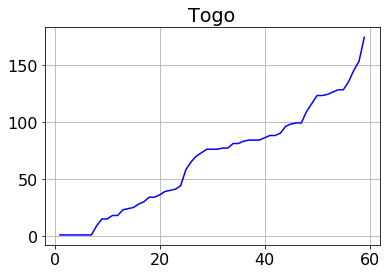

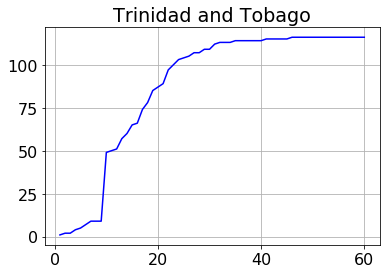

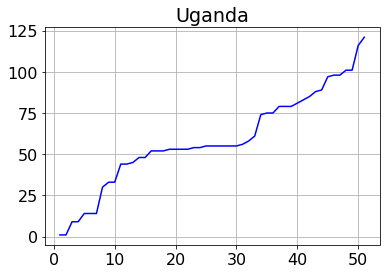

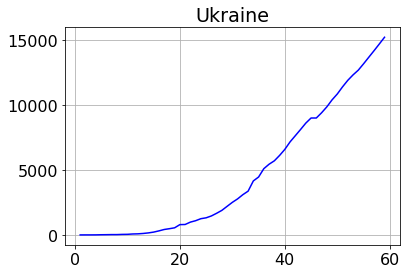

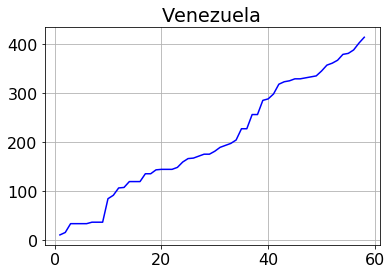

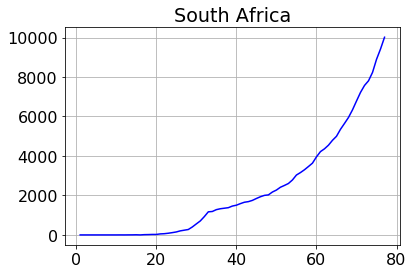

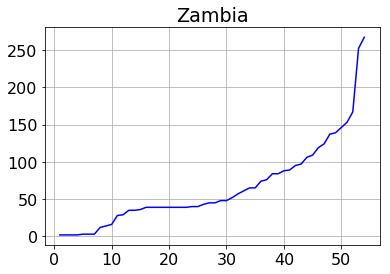

******************** cluster 1 ********************


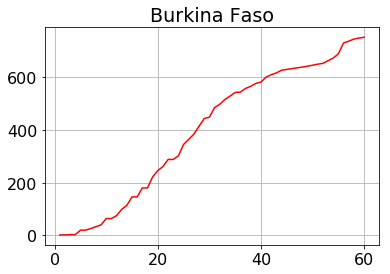

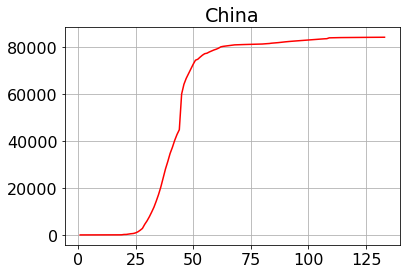

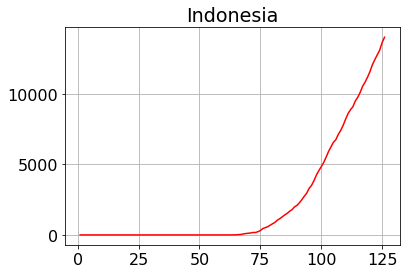

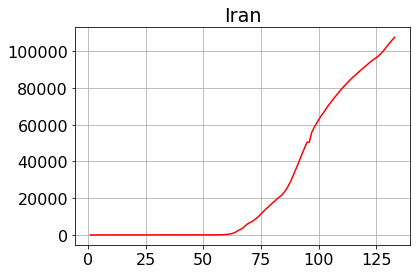

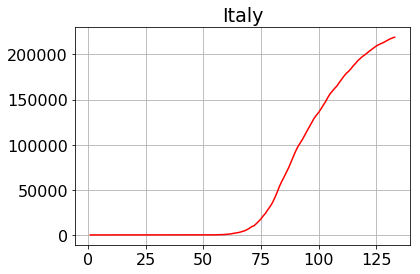

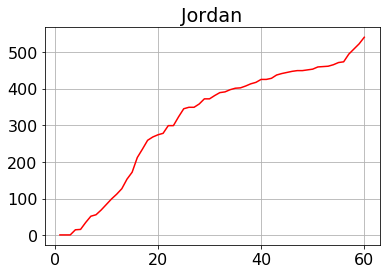

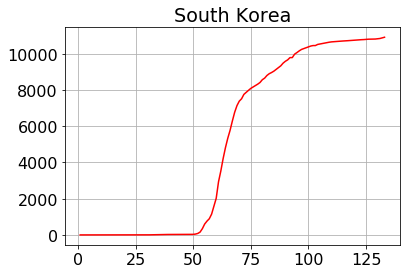

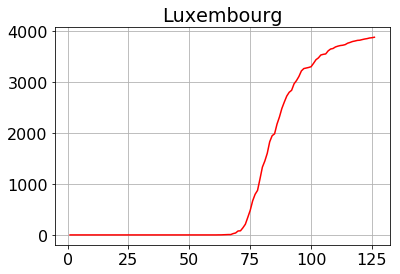

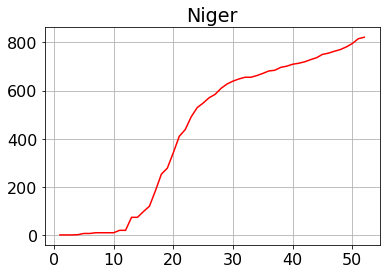

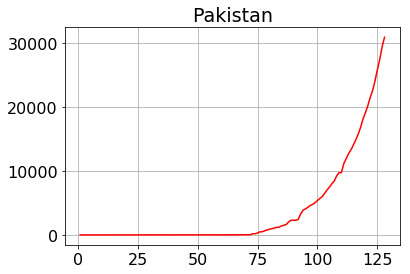

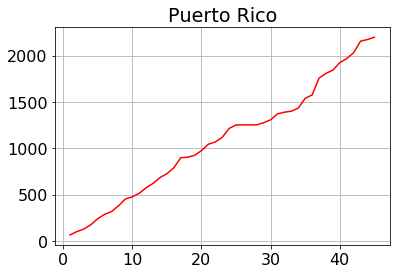

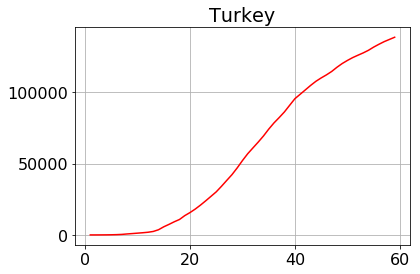

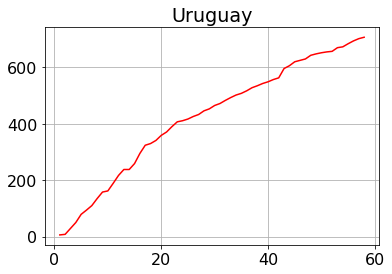

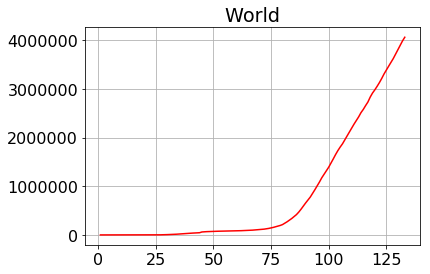

******************** cluster 2 ********************


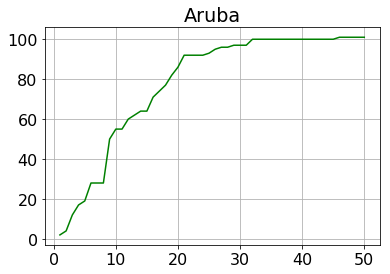

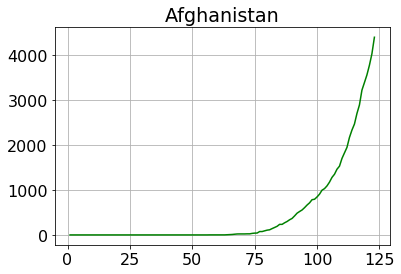

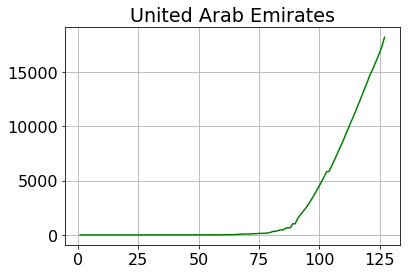

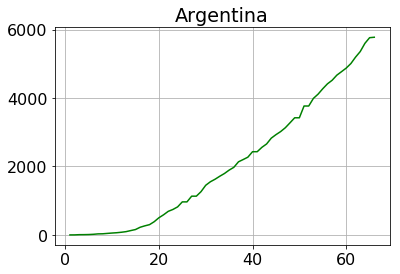

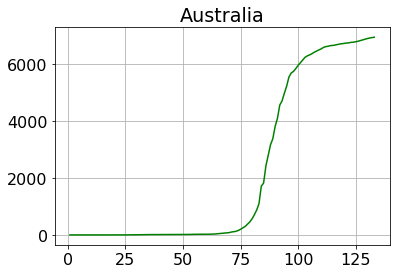

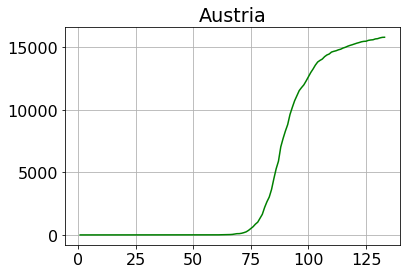

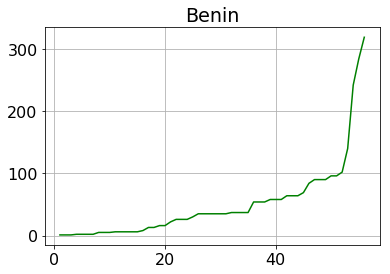

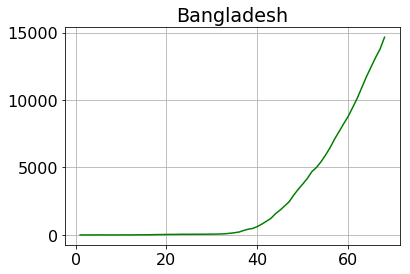

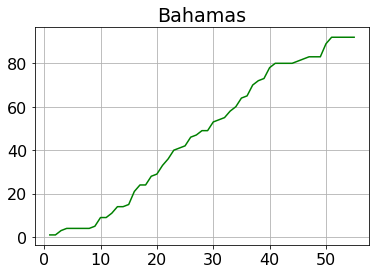

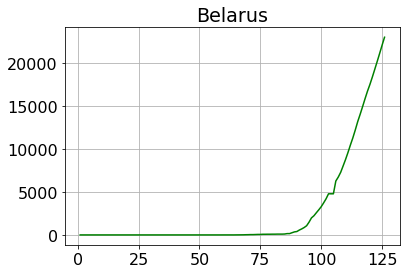

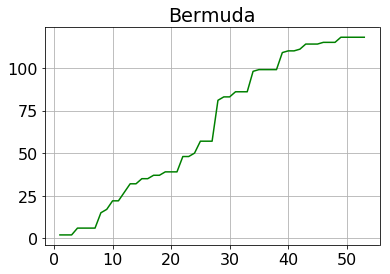

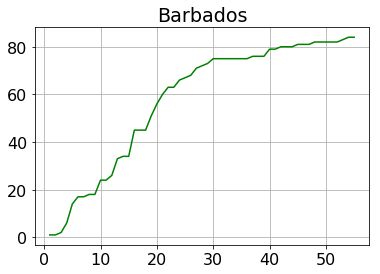

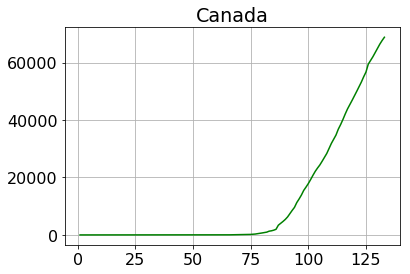

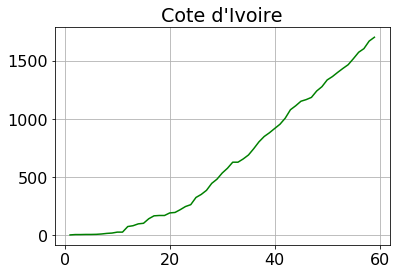

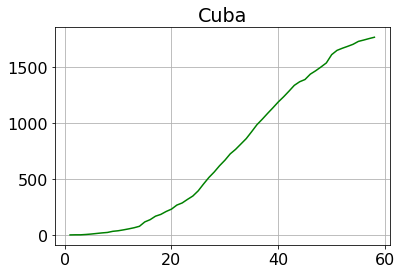

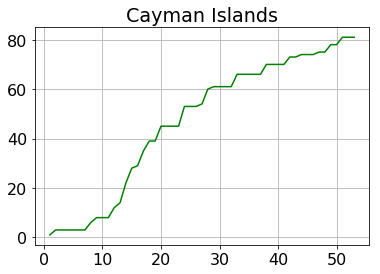

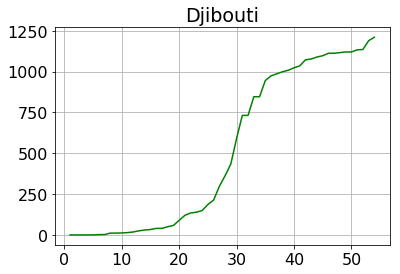

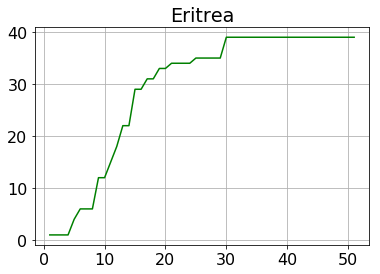

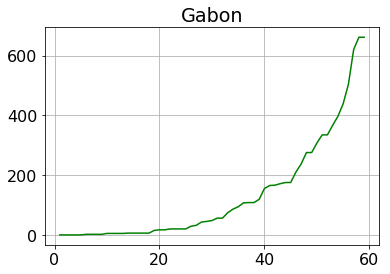

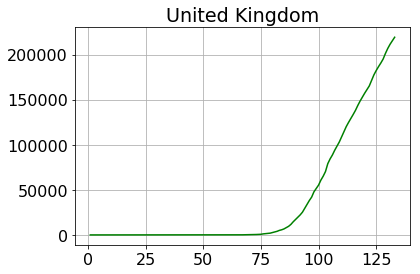

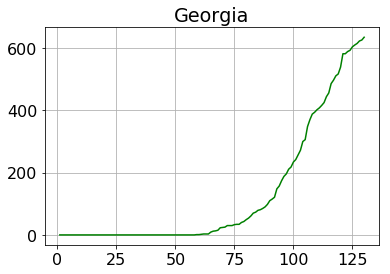

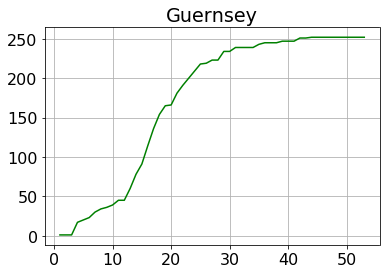

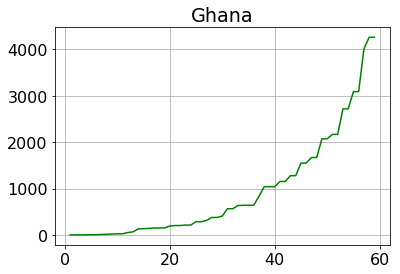

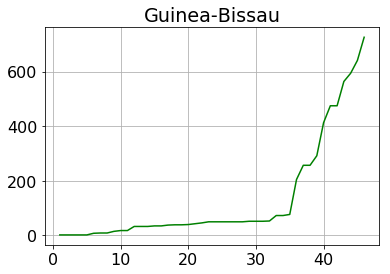

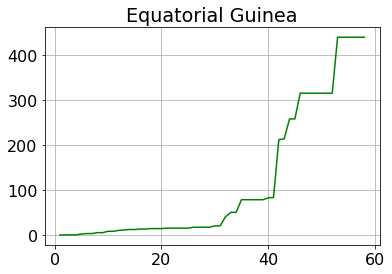

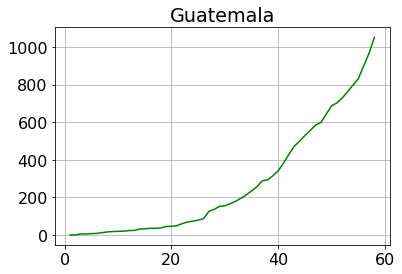

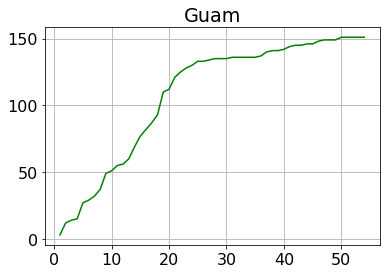

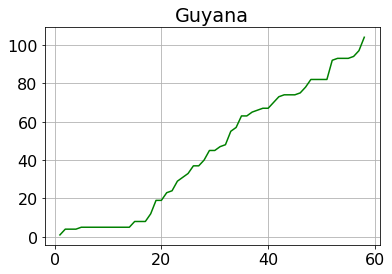

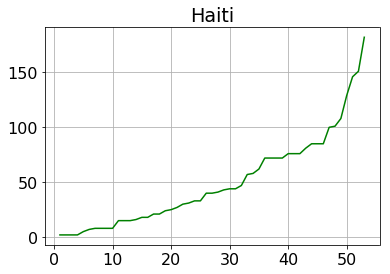

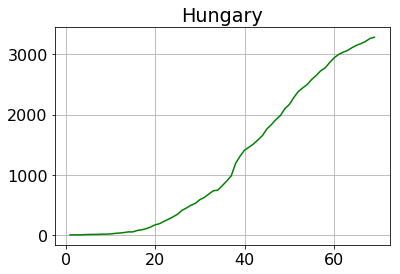

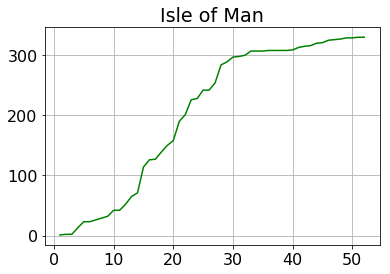

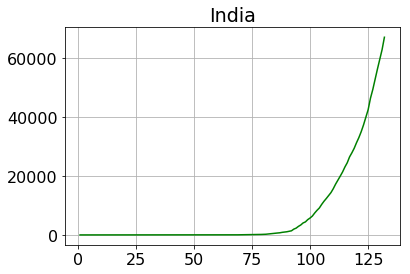

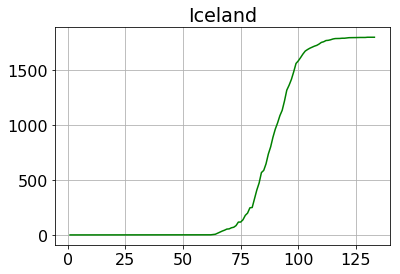

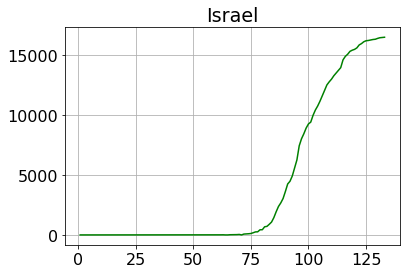

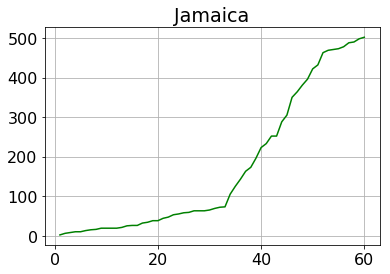

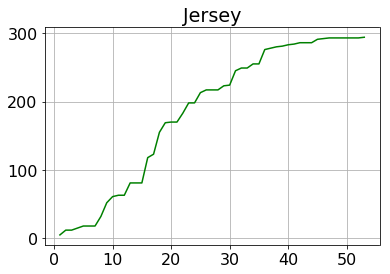

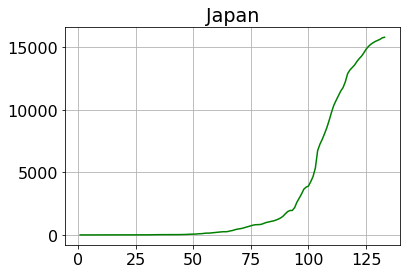

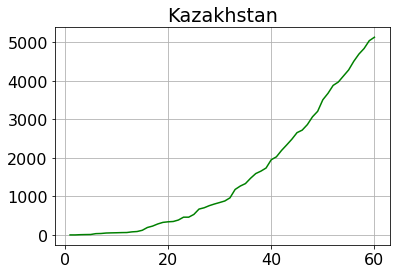

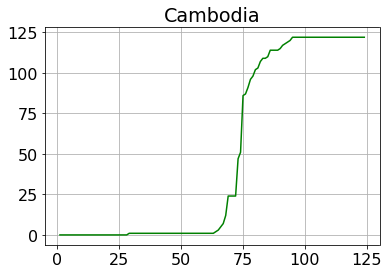

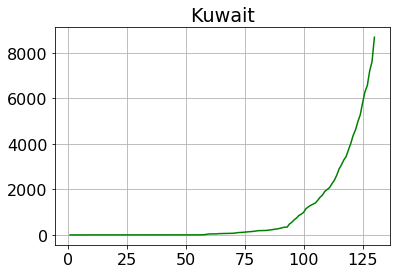

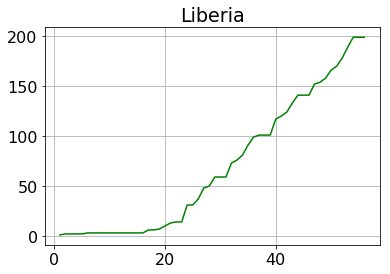

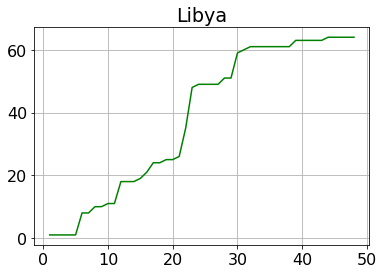

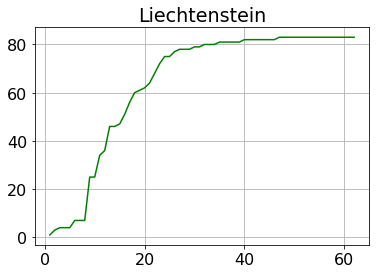

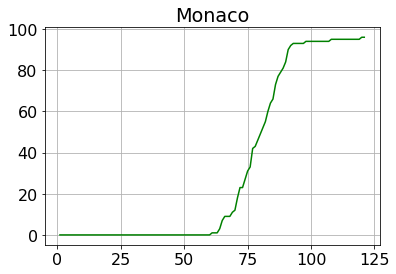

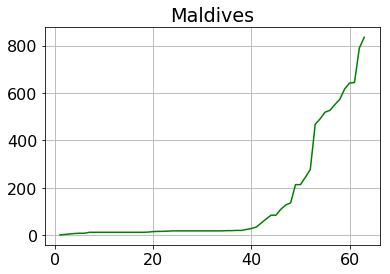

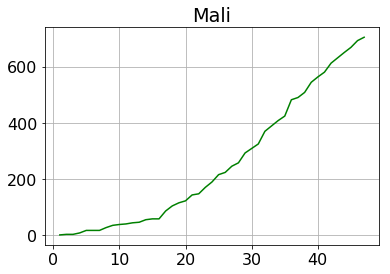

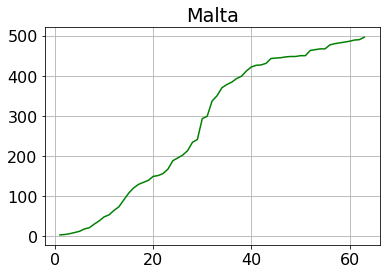

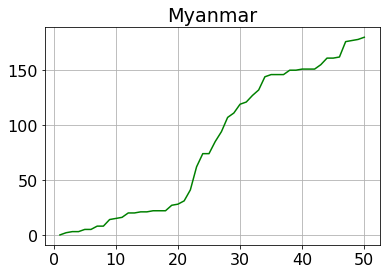

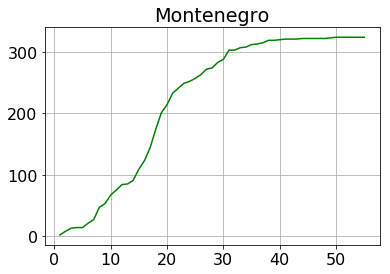

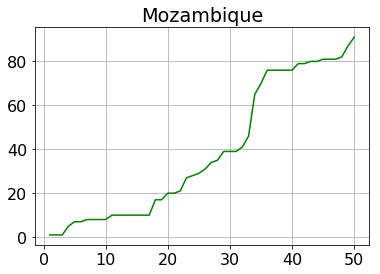

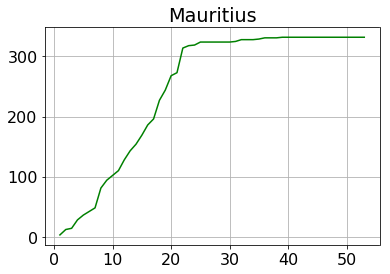

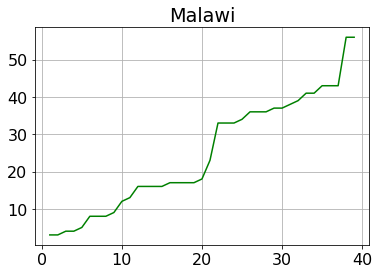

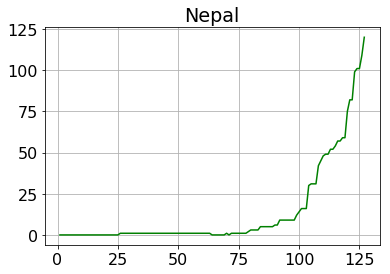

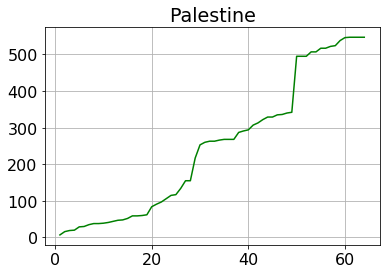

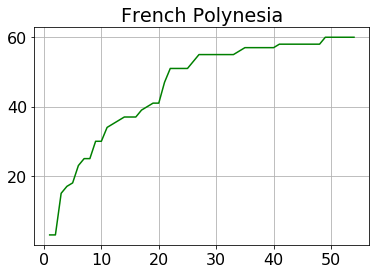

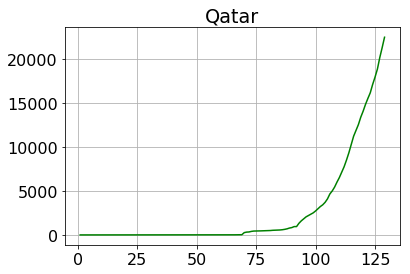

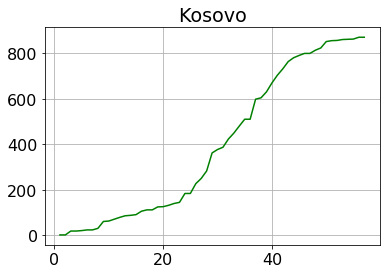

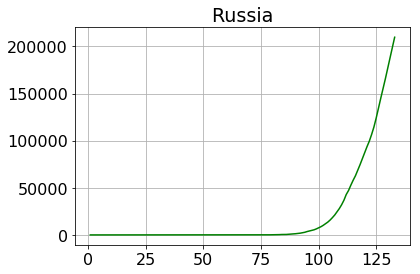

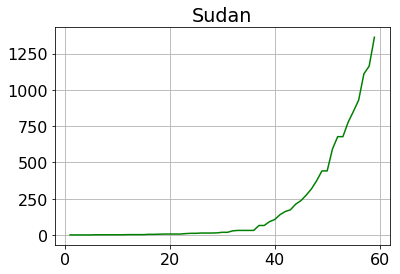

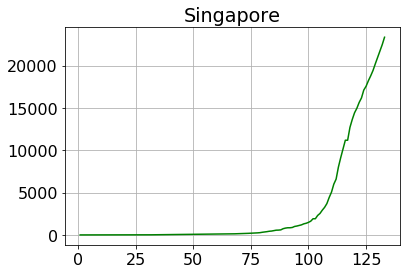

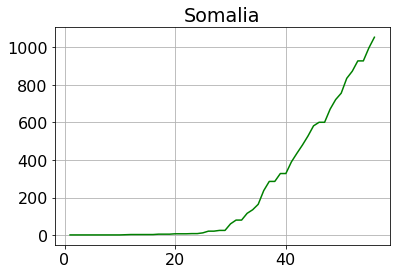

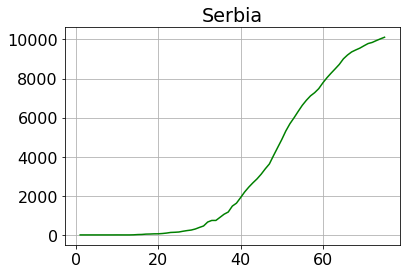

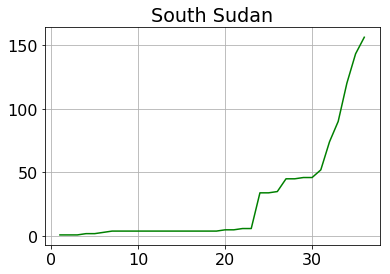

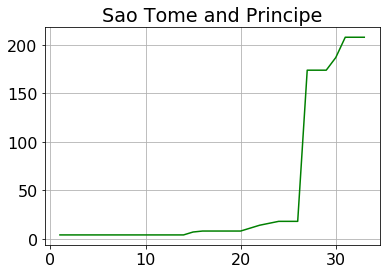

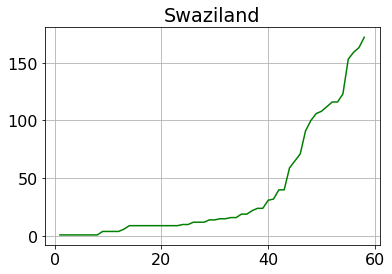

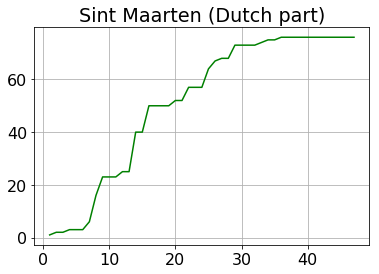

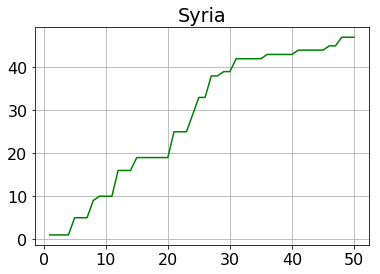

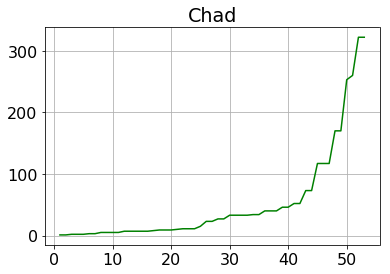

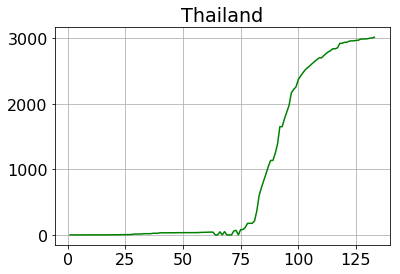

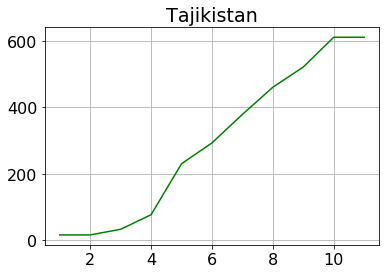

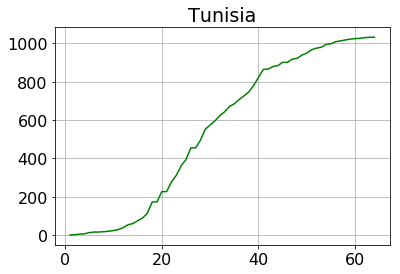

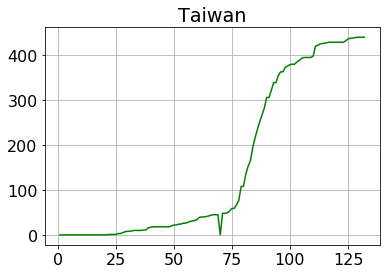

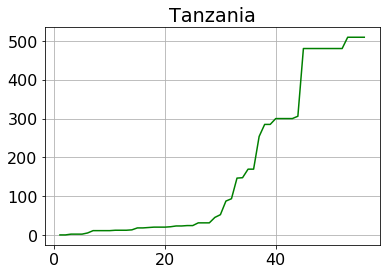

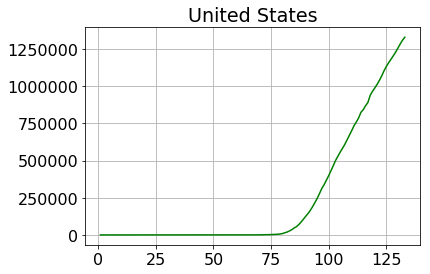

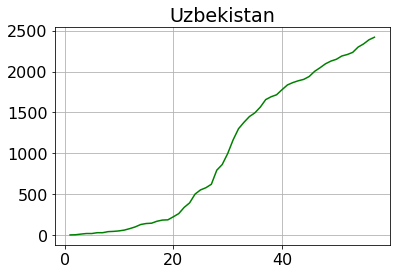

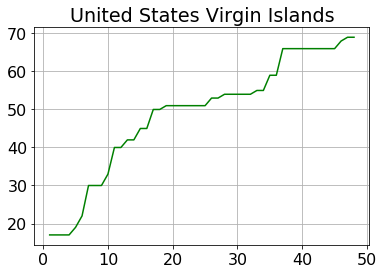

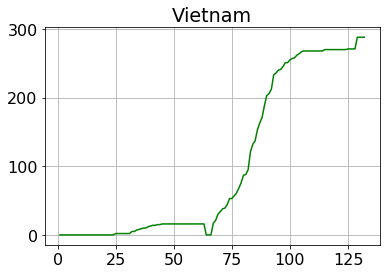

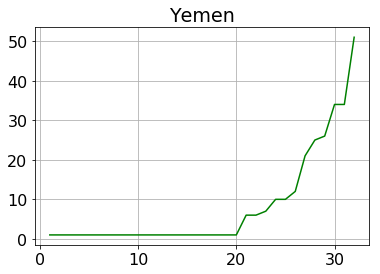

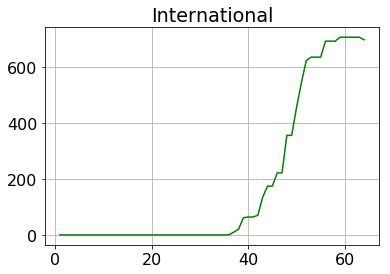

In [74]:
for i in range(n_clusters):
    Loc = Location[predict_clusters == i]
    print("*"*20, f"cluster {i}","*"*20)
    for loc in Loc:
        total_case = df[df.location == loc].total_cases.values
        plt.plot(np.arange(1,len(total_case)+1), total_case, c = c[i])
        plt.title(loc)
        plt.grid()
        plt.show()

Сходу трудной понять, что объеденяет кривые из одного кластера.

Вспомним гистограмму для параметра $\theta_2$

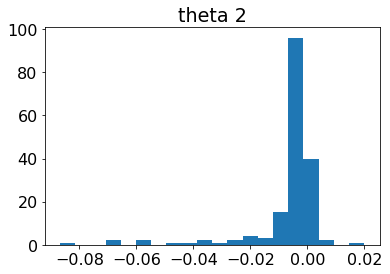

In [75]:
plt.hist(Theta_opt[:,2], bins=20)
plt.title("theta 2")
plt.show()

$\theta_2$ - это коэффициент перед квадратичным членом, интересно посмотреть, как ведут себя кривые с разными знаками перед $\theta_2$.

In [76]:
theta_2_opt = Theta_opt[:,2]

In [77]:
Loc_plus = Location[theta_2_opt > 0]
Loc_minus = Location[theta_2_opt <= 0]

Визуализируем кривые с положительным коэффициентом перед $x^2$

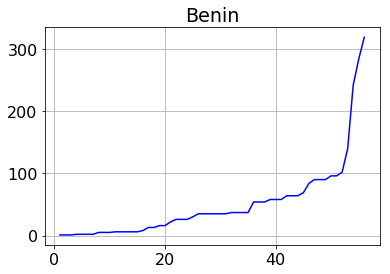

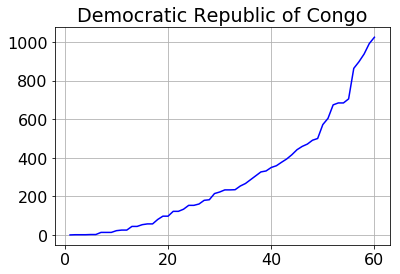

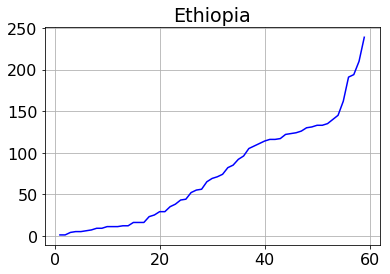

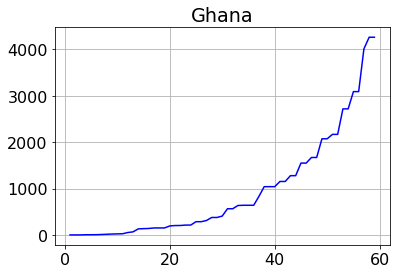

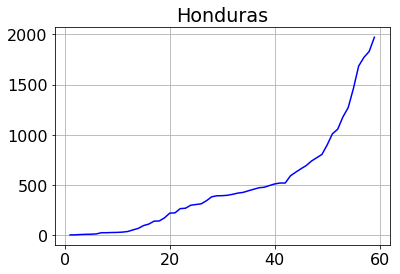

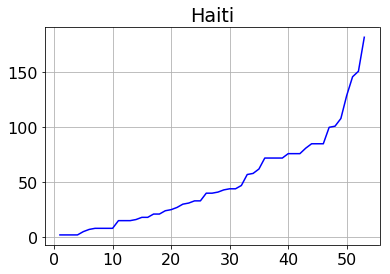

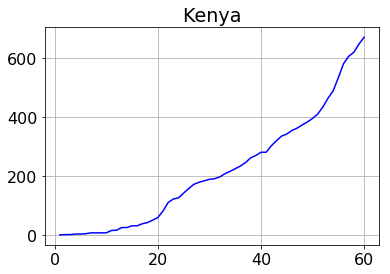

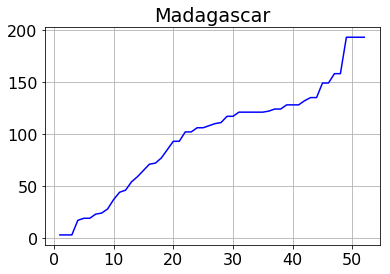

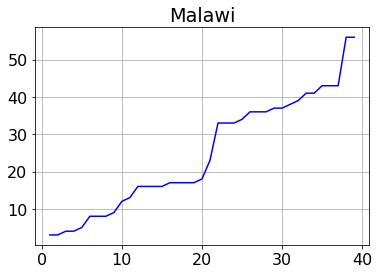

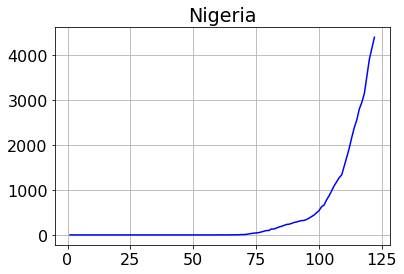

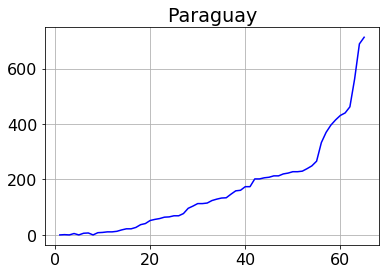

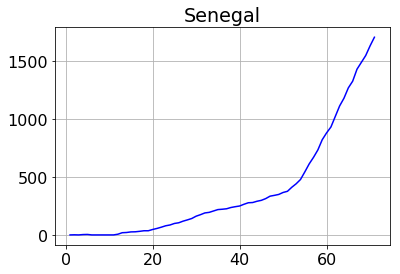

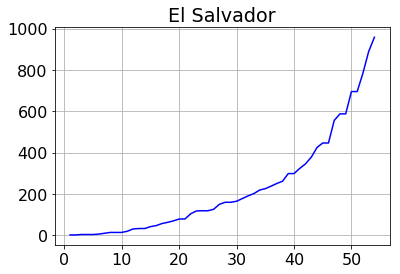

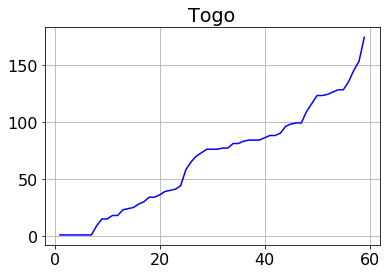

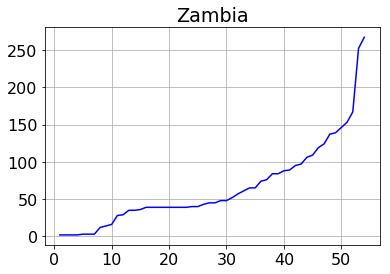

In [78]:
for loc in Loc_plus:
    total_case = df[df.location == loc].total_cases.values
    plt.plot(np.arange(1,len(total_case)+1), total_case, c = c[0])
    plt.title(loc)
    plt.grid()
    plt.show()

Визуализируем кривые с отрицательным коэффициентом перед $x^2$

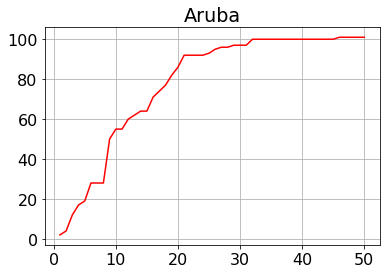

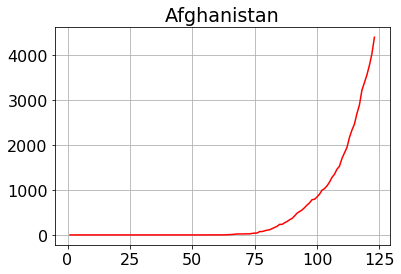

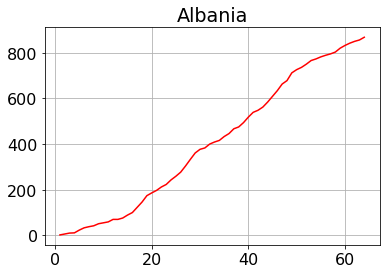

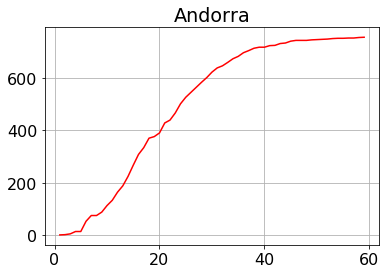

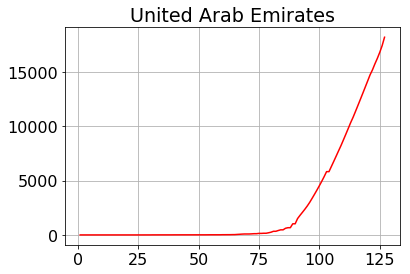

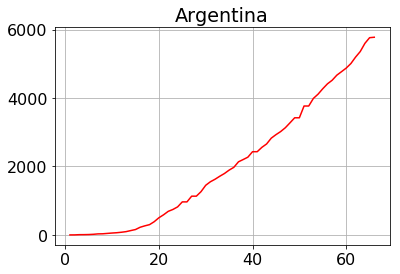

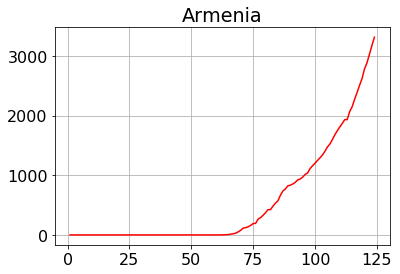

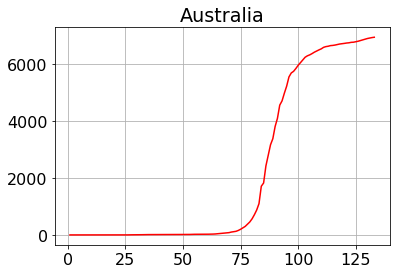

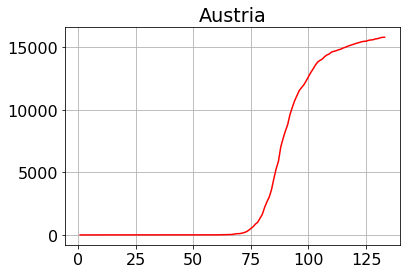

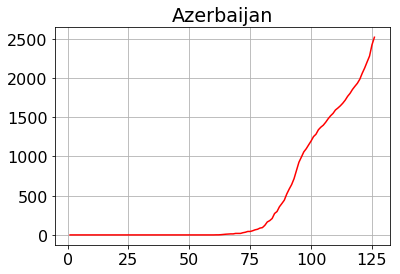

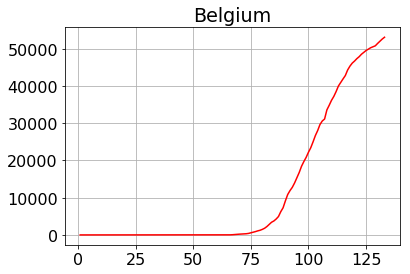

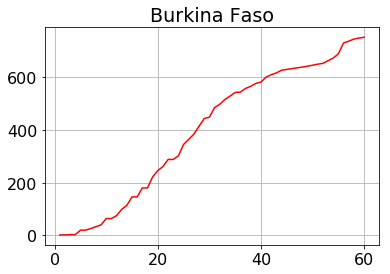

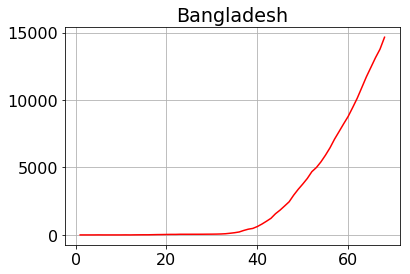

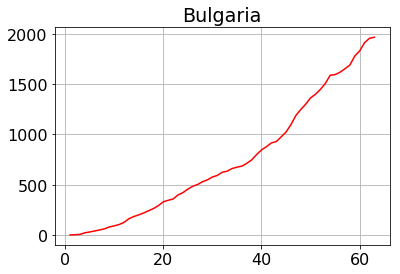

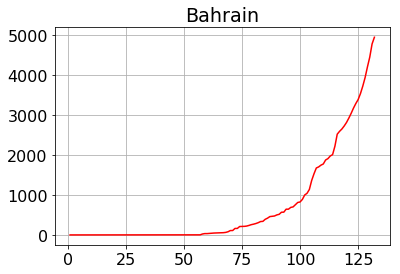

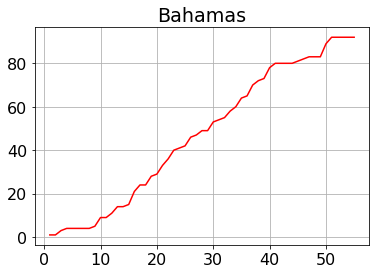

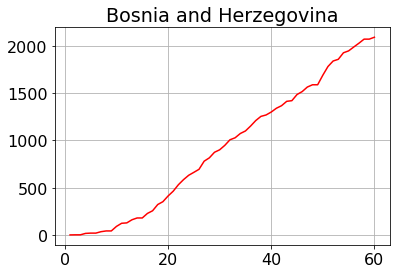

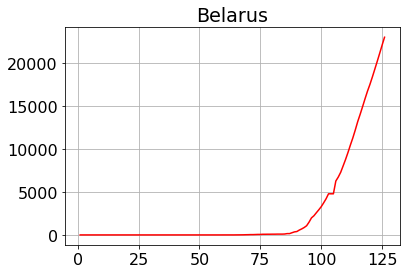

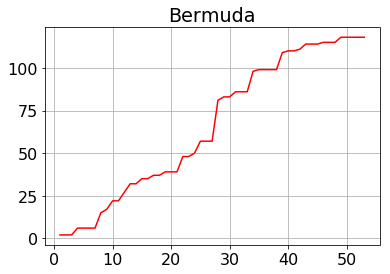

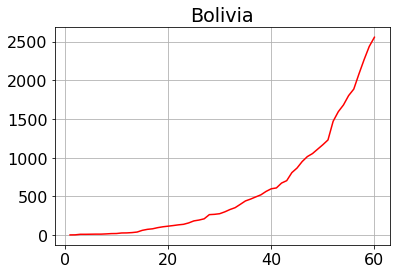

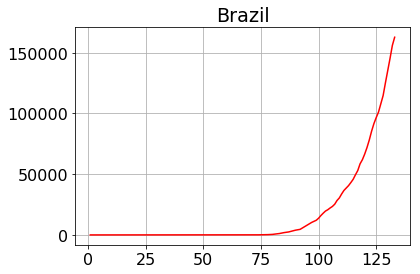

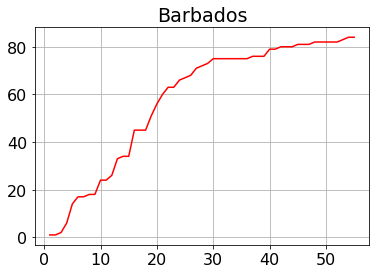

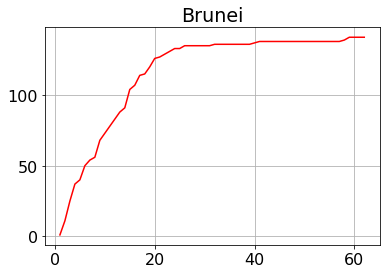

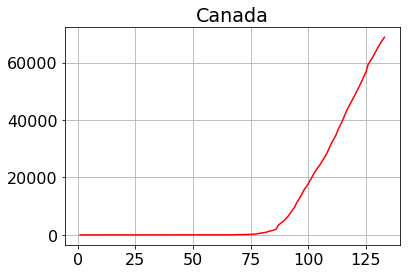

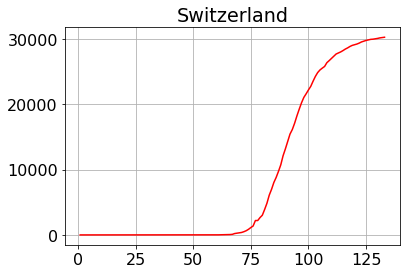

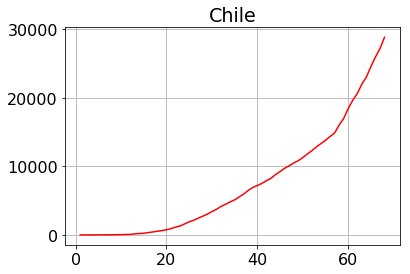

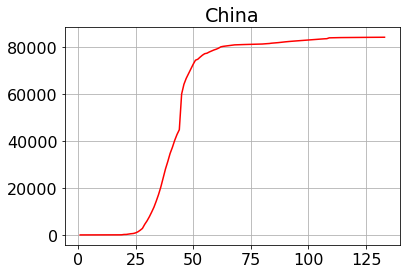

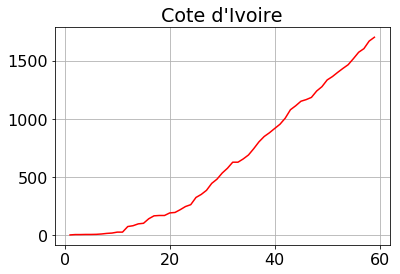

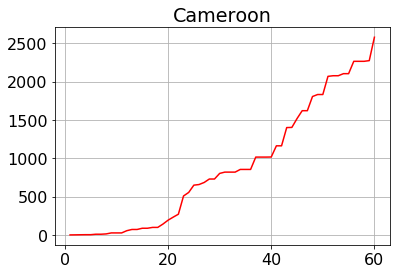

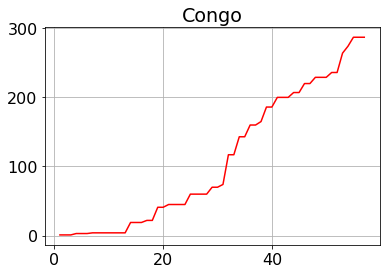

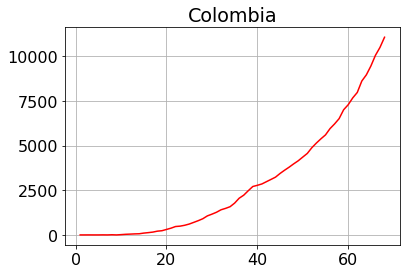

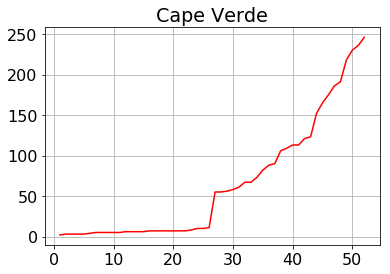

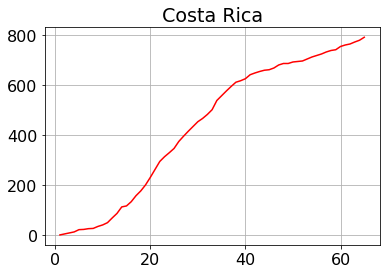

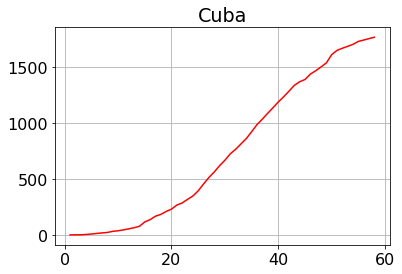

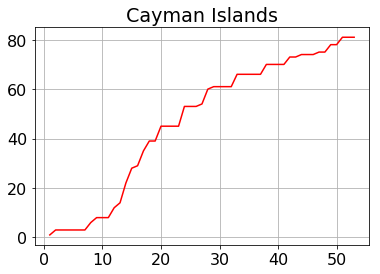

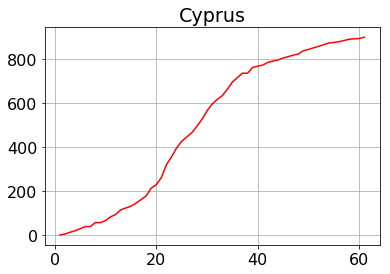

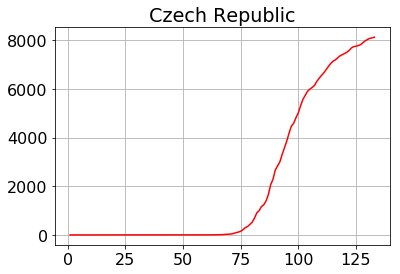

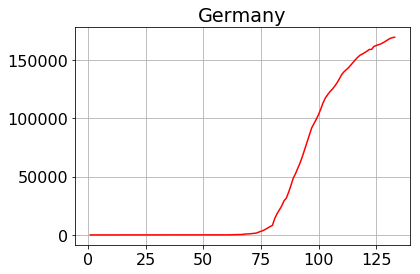

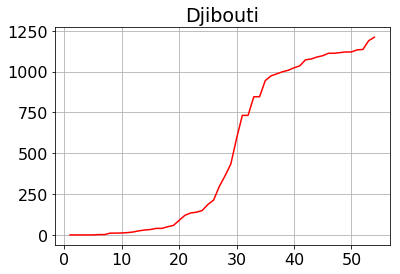

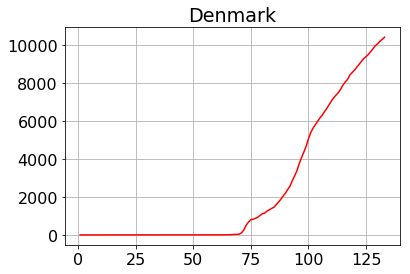

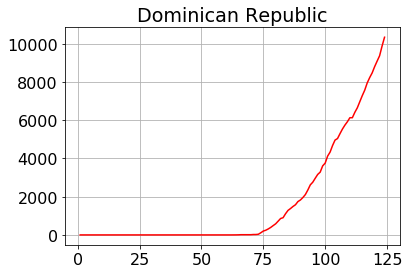

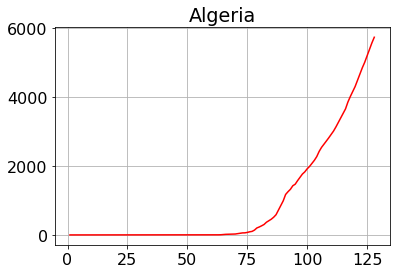

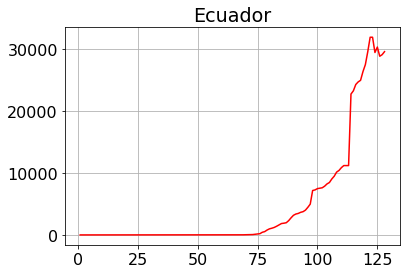

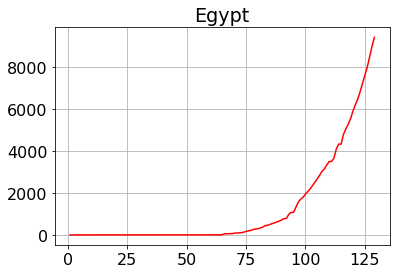

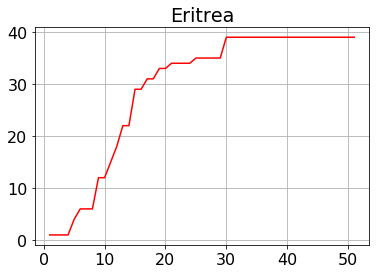

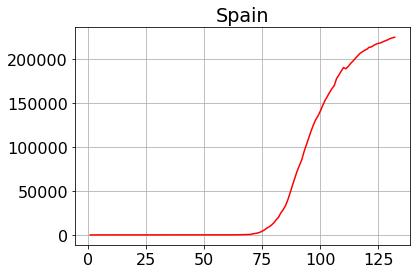

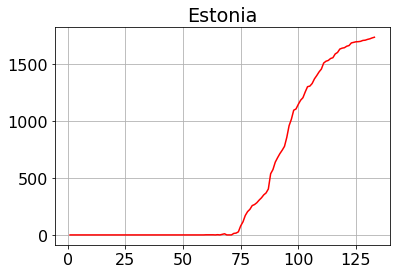

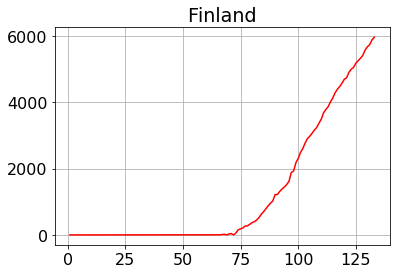

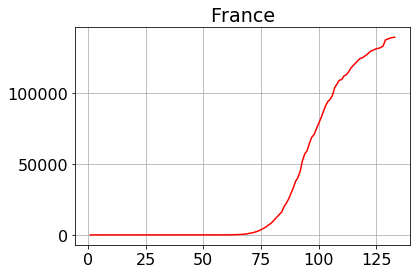

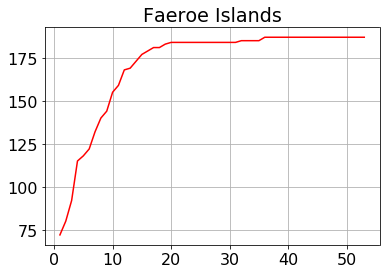

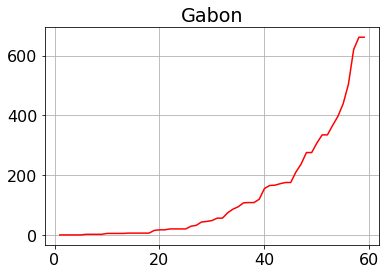

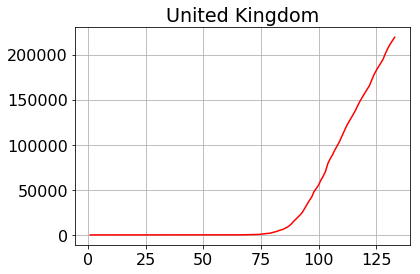

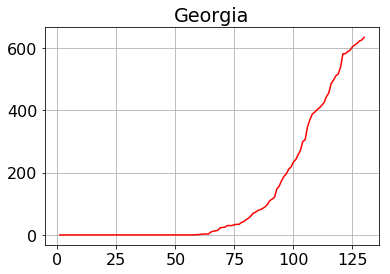

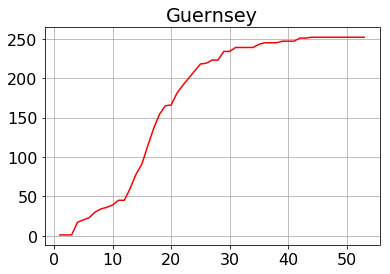

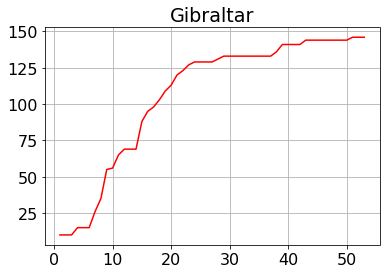

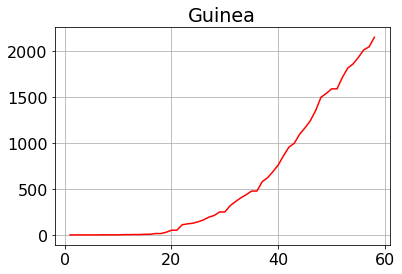

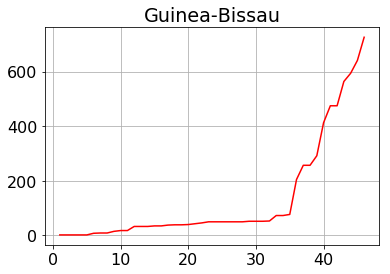

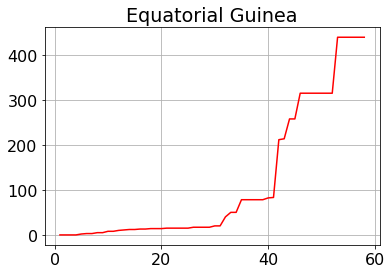

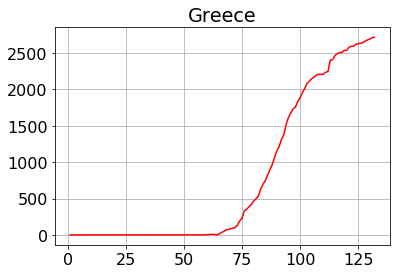

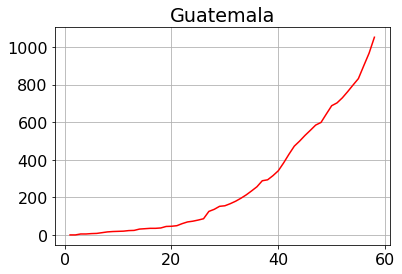

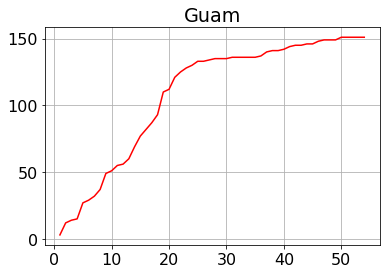

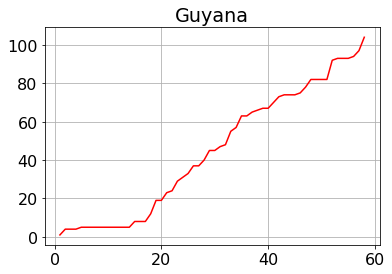

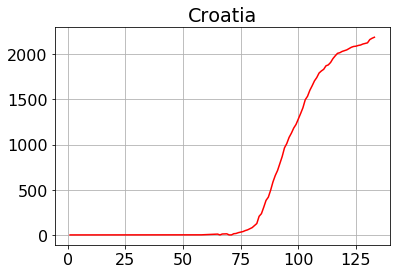

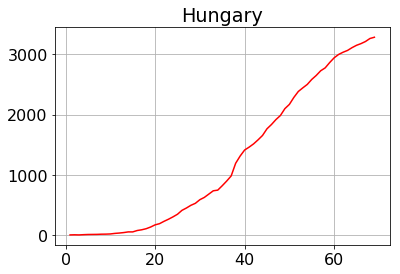

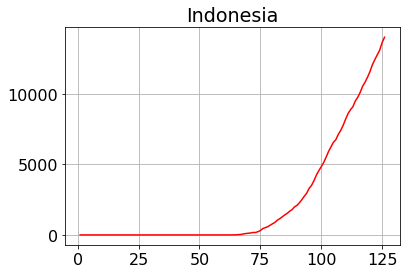

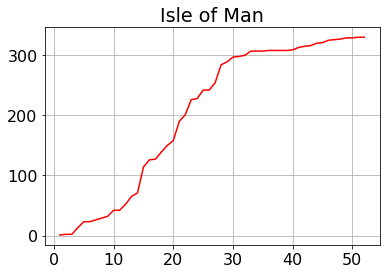

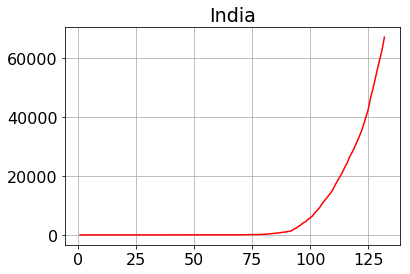

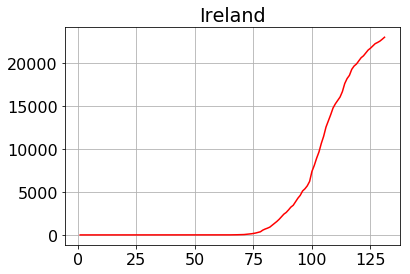

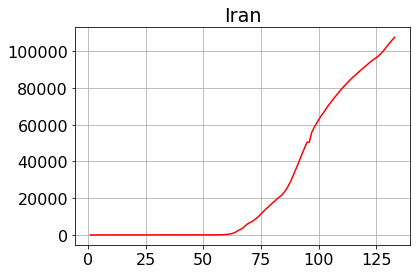

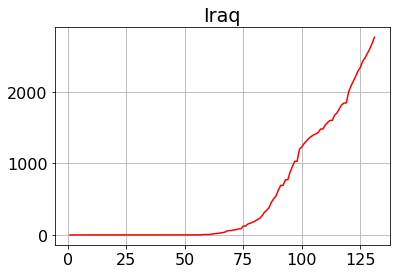

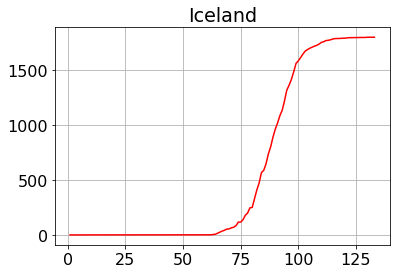

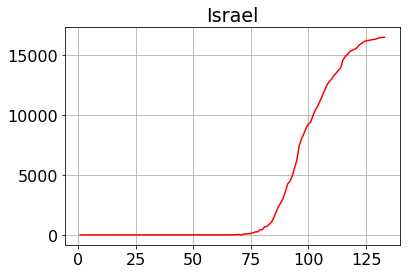

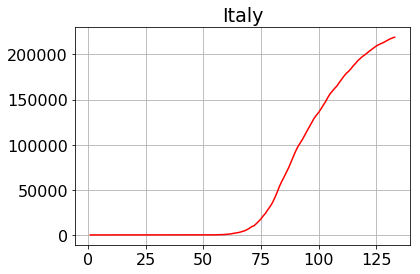

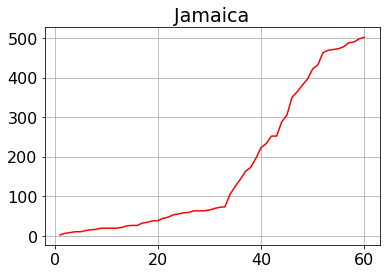

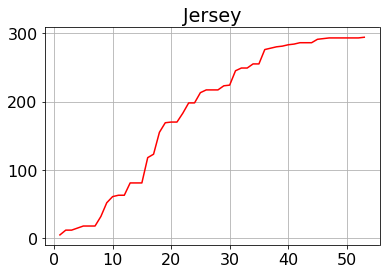

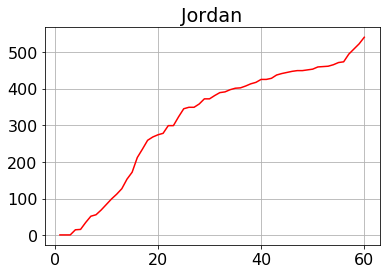

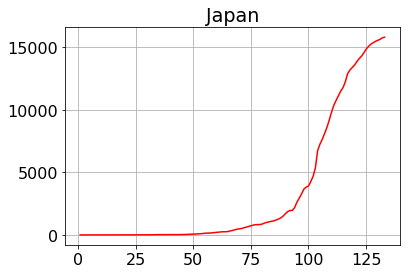

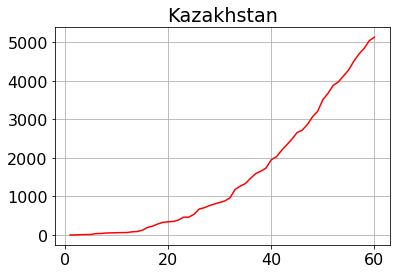

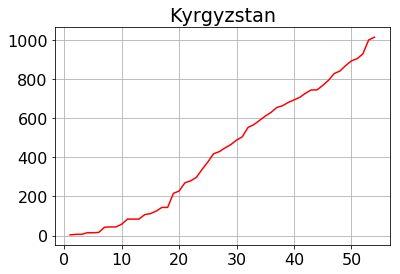

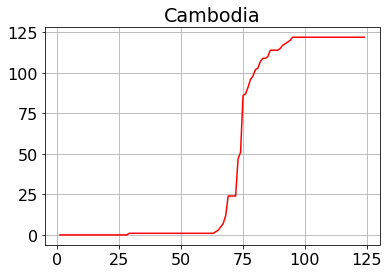

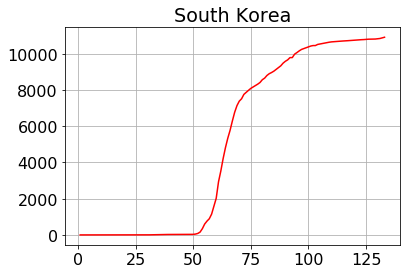

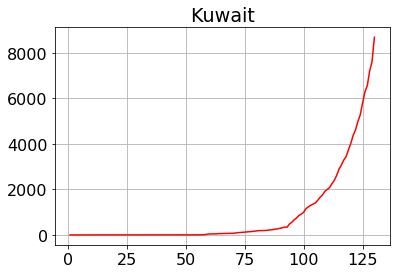

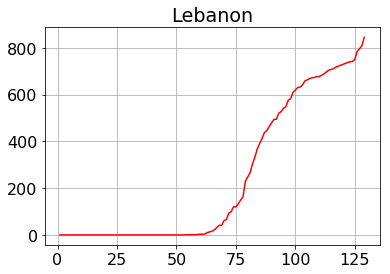

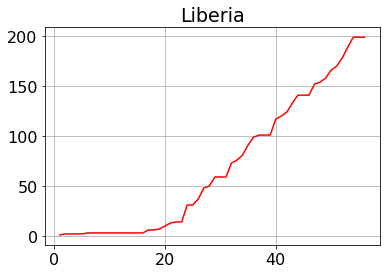

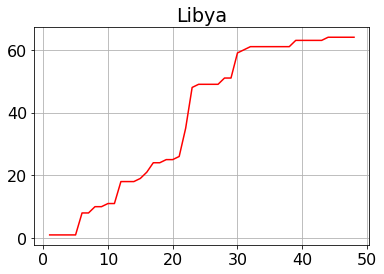

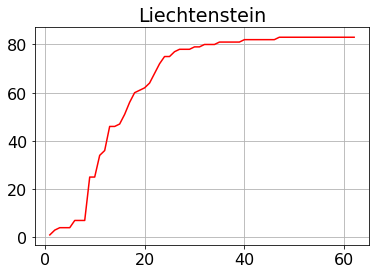

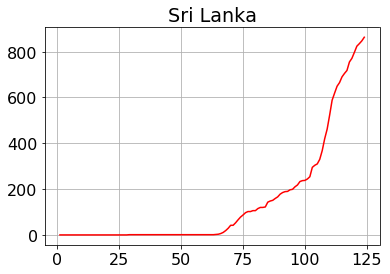

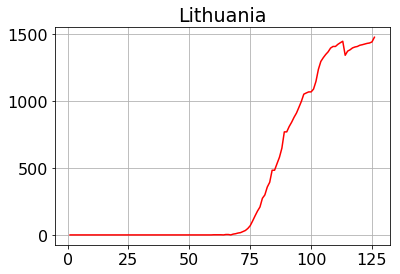

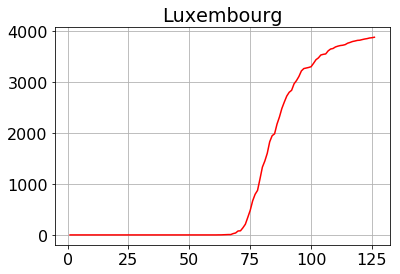

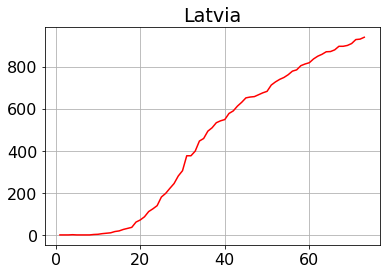

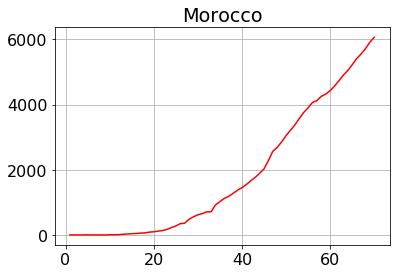

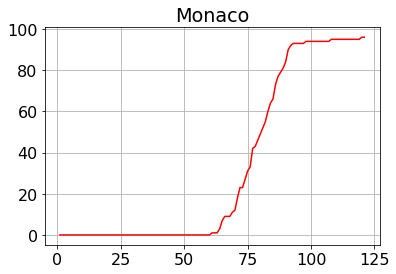

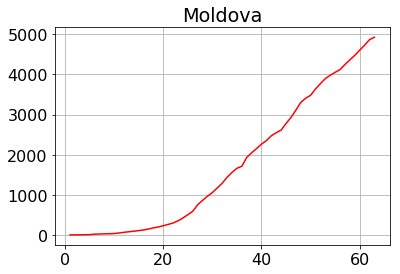

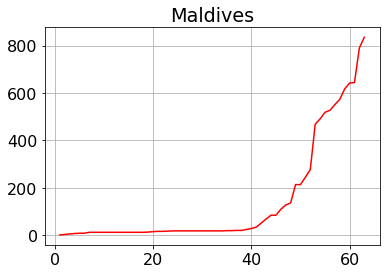

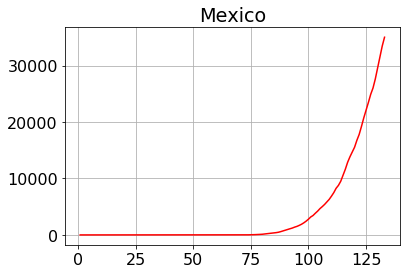

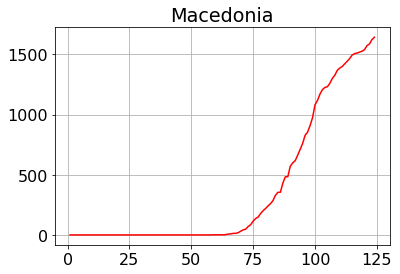

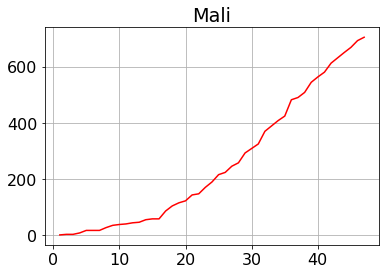

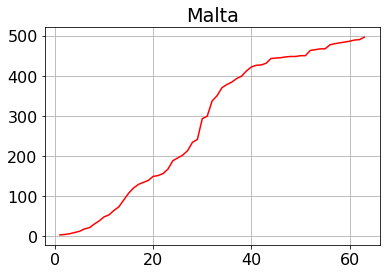

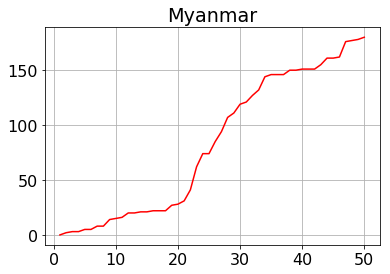

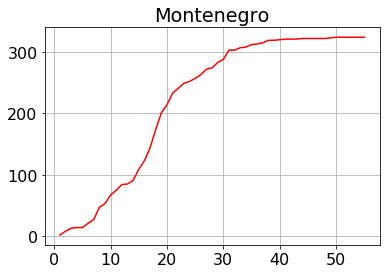

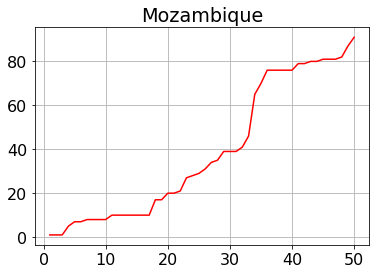

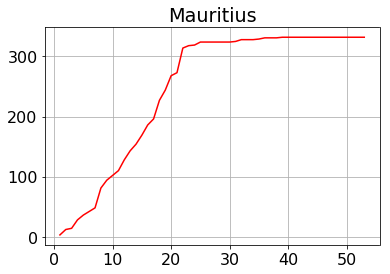

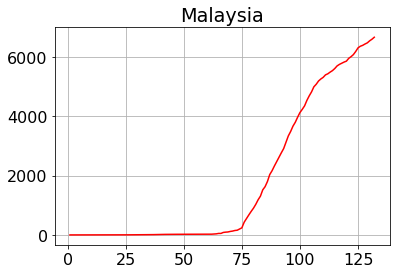

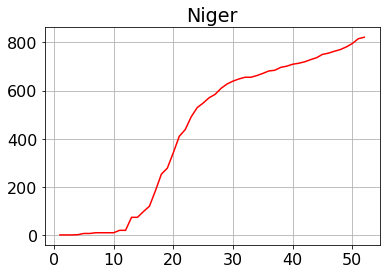

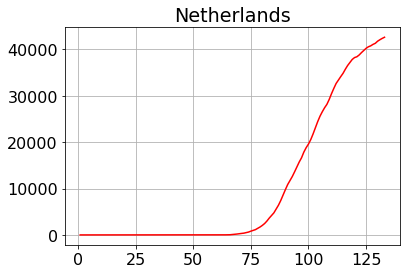

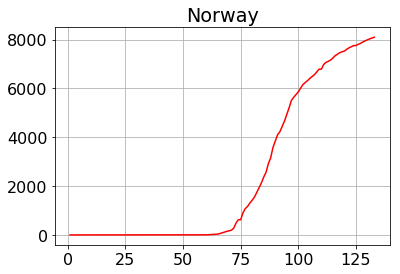

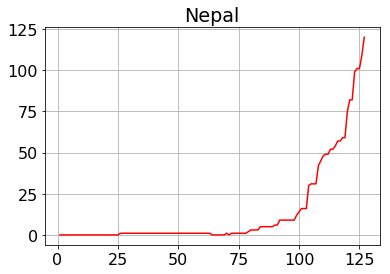

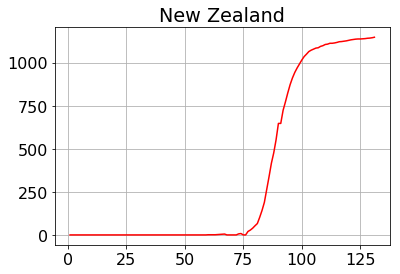

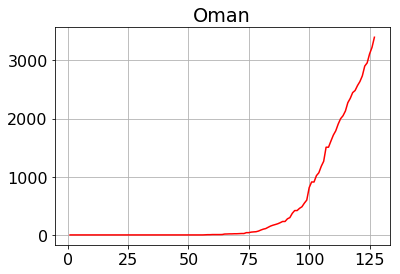

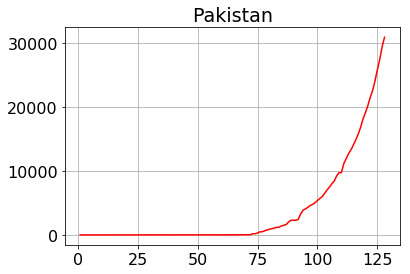

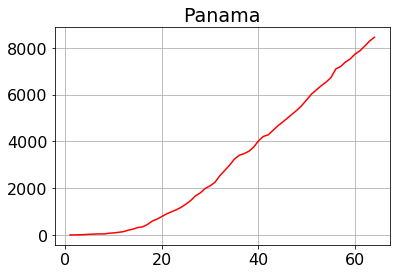

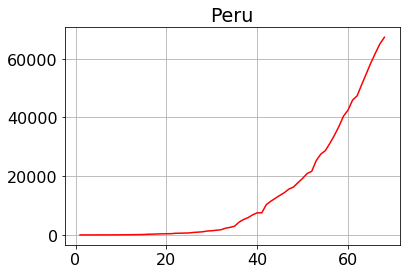

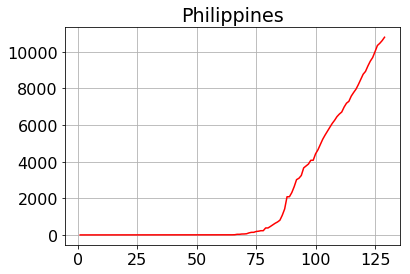

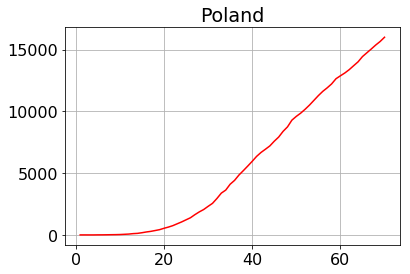

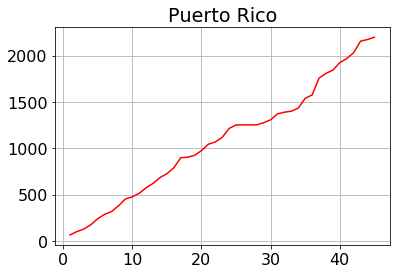

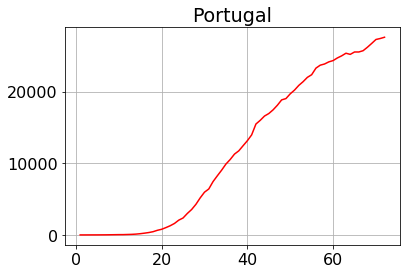

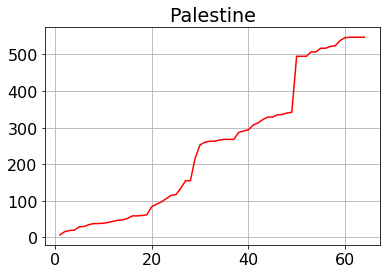

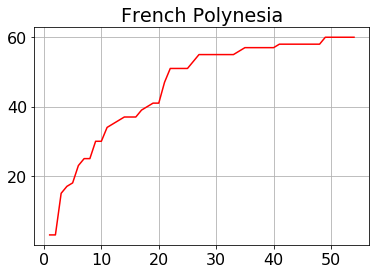

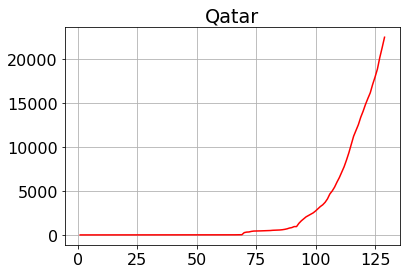

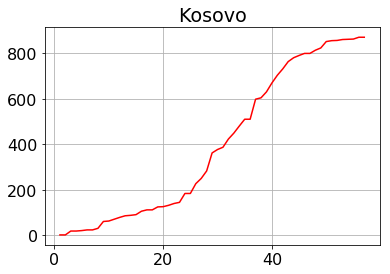

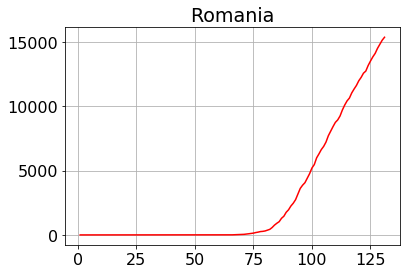

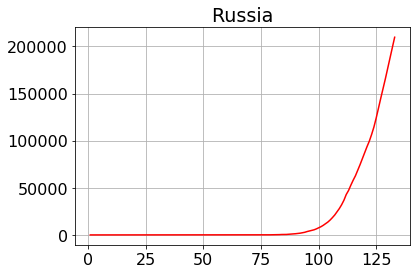

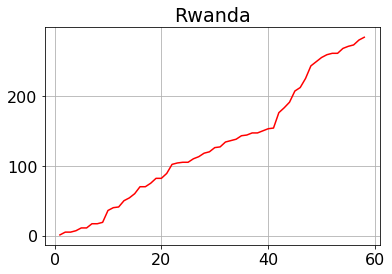

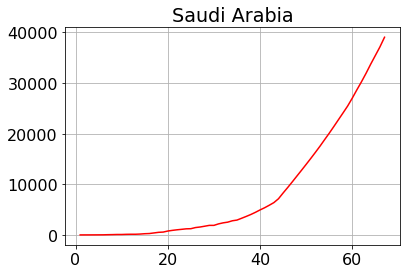

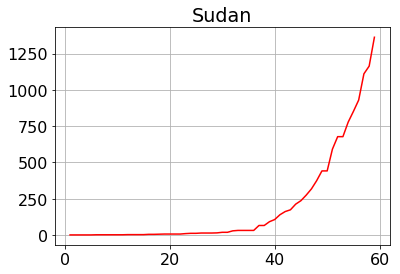

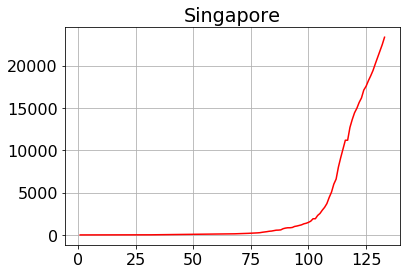

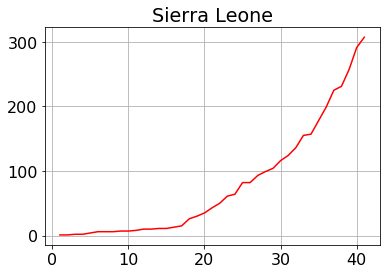

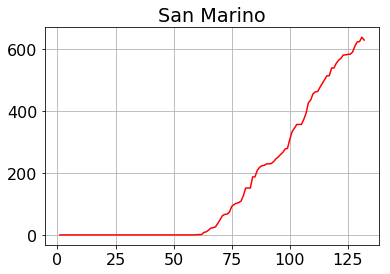

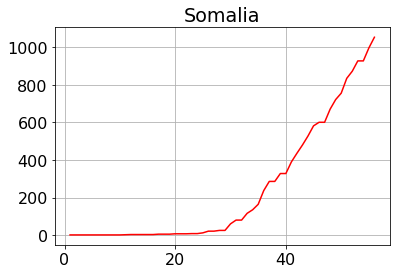

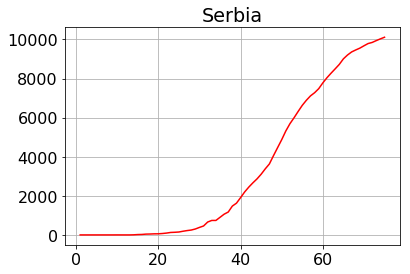

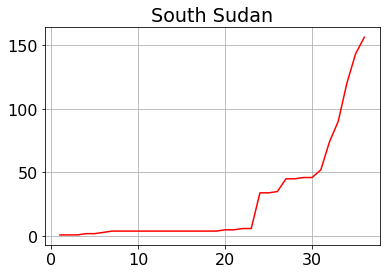

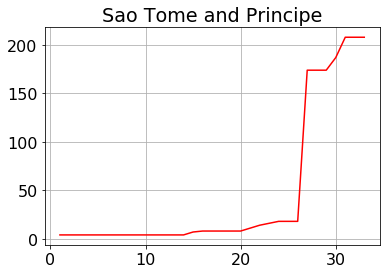

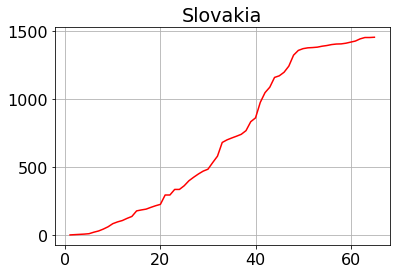

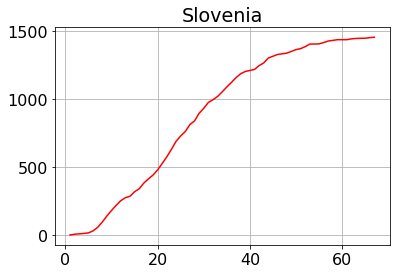

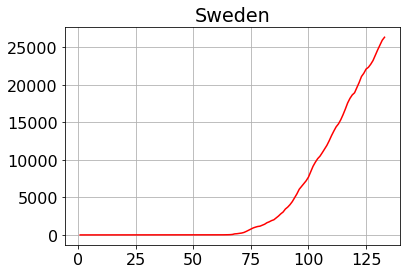

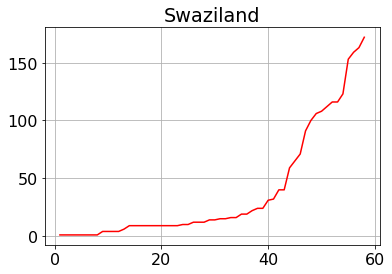

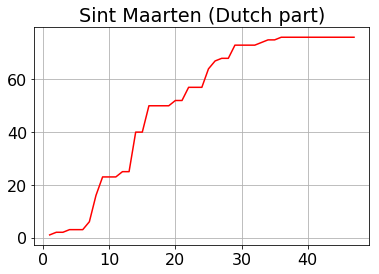

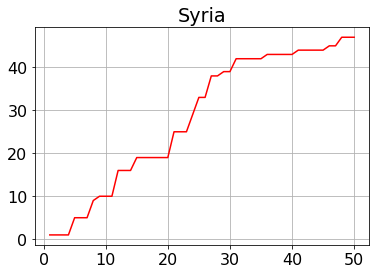

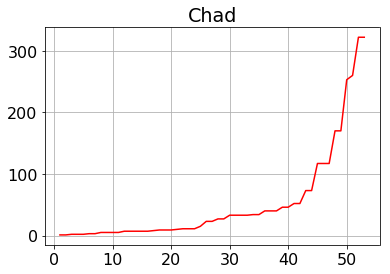

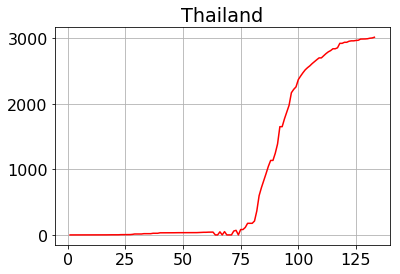

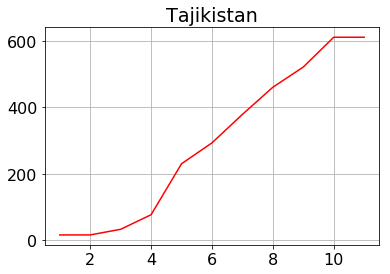

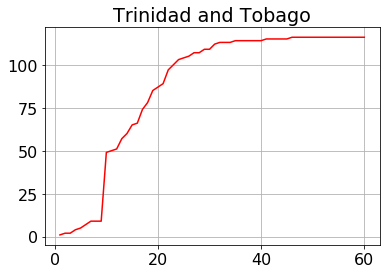

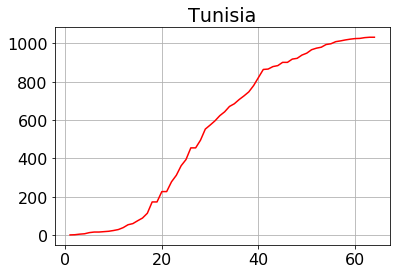

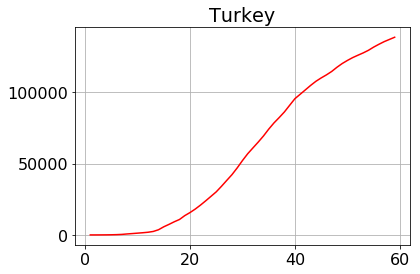

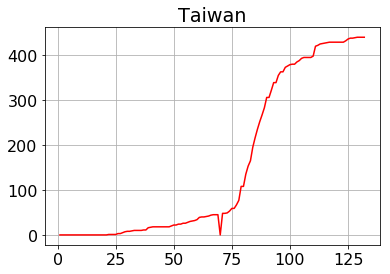

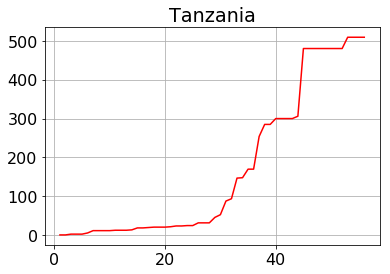

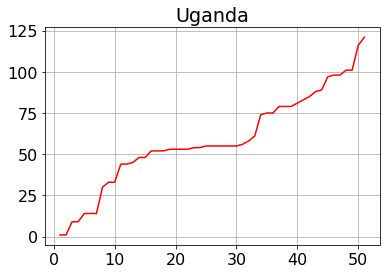

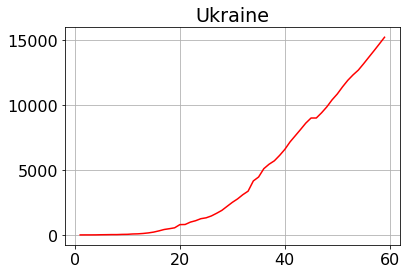

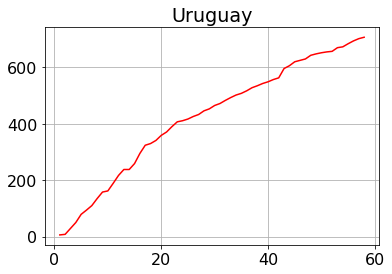

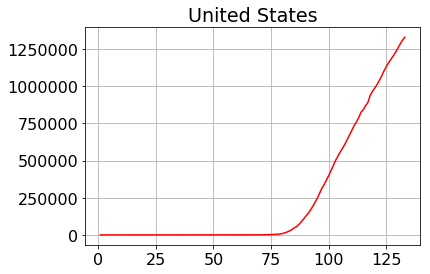

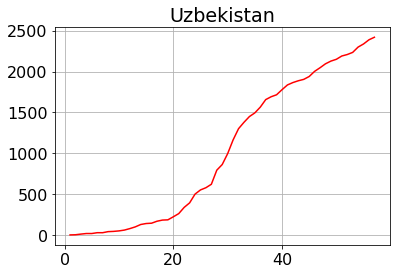

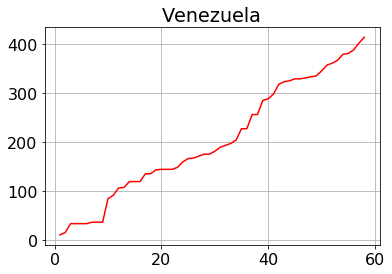

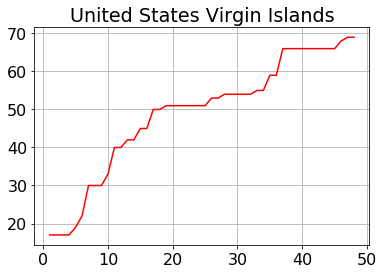

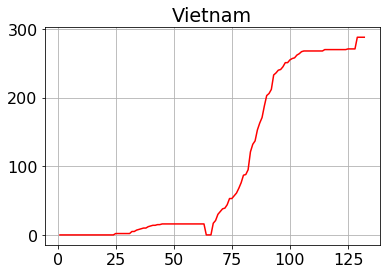

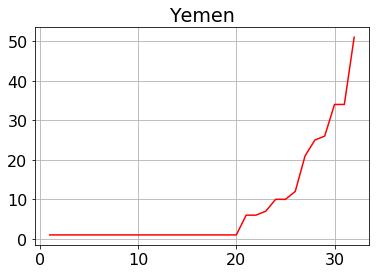

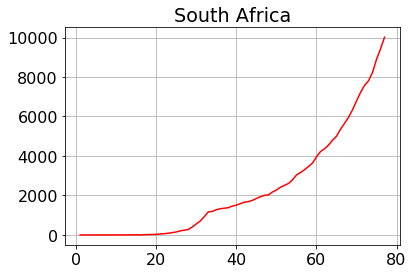

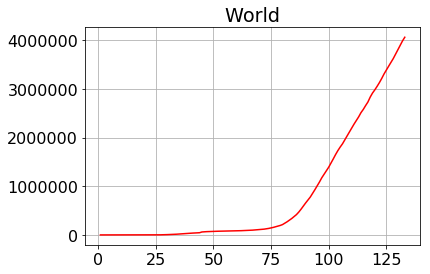

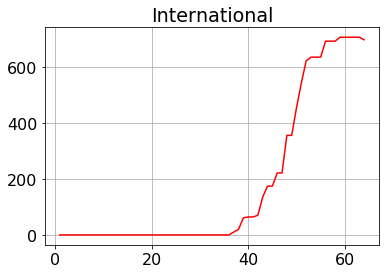

In [79]:
for loc in Loc_minus:
    total_case = df[df.location == loc].total_cases.values
    plt.plot(np.arange(1,len(total_case)+1), total_case, c = c[1])
    plt.title(loc)
    plt.grid()
    plt.show()

Видим, что у кривых с положительным коэффициентом перед $x^2$ - наблюдается только сильный рост, без насыщения сигмоида. К томуже все страны очень жаркие, в основном это страны Африки, зараженных в этих страно относительно мало.